In [33]:
import os
import numpy as np
import pandas as pd
import re
import io
import json
from pandas.io.json import json_normalize
import csv
import random
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from datetime import datetime
import seaborn as sns
import pickle

from scipy.interpolate import UnivariateSpline
from sklearn.metrics import roc_curve, auc
from scipy.signal import find_peaks

pd.set_option('display.max_colwidth', None)

In [34]:
from sklearn.model_selection import GroupKFold, KFold

import tensorflow as tf  

from tensorflow import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv1D, Conv2D, Conv2DTranspose,Convolution2D, Conv3D, ConvLSTM2D, Bidirectional
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Activation, SpatialDropout1D, SpatialDropout2D, LayerNormalization, GlobalAvgPool1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import Callback

import tensorflow.keras.backend as K

from tensorflow_addons.layers import WeightNormalization
from tensorflow_addons.optimizers import AdamW 

In [207]:
#Opening numpy arrays for sex    
suffix = 'corrected_60k_sex'           #non-null- 56,665 ECGs; will use 53,665 in training set

ecg_X_k = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_X.npy')
ecg_y_k = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_yfemale.npy')

ecg_X_k = ecg_X_k[ecg_y_k>=0]
ecg_y_k = ecg_y_k[ecg_y_k>=0]

print(ecg_X_k.shape)
print(ecg_y_k.shape)

np.unique(ecg_y_k)

(56665, 60000, 1)
(56665,)


array([0, 1])

In [3]:
#opening numpy arrays for sex test set

ecg_X_k = np.load('MGH_60k_500hz_ecgs_age_18_100_test_X.npy')
ecg_y_k = np.load('MGH_60k_500hz_ecgs_age_18_100_test_y.npy')

ecg_X_k = ecg_X_k[ecg_y_k>=0]
ecg_y_k = ecg_y_k[ecg_y_k>=0]

print(ecg_X_k.shape)
print(ecg_y_k.shape)

np.unique(ecg_y_k)

(2908, 60000, 1)
(2908,)


array([0, 1])

In [49]:
#Opening numpy arrays for age    #57,000; 54,150 in training with 20-fold
suffix = 'corrected_60k_age'

ecg_X_k = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_X.npy')
ecg_y_k = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_yage.npy')

In [52]:
ecg_X_k = ecg_X_k[ecg_y_k>0]
ecg_y_k = ecg_y_k[ecg_y_k>0]

In [53]:
print(ecg_X_k.shape)
print(ecg_y_k.shape)

(57000, 60000, 1)
(57000,)


In [ ]:
#selecting only X and y elements in 60k dataset where rhythm is sinus

In [38]:
trainval_sinus = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_sinus.npy')

In [ ]:
#get measurements

In [41]:
ecg_filename_k = np.load('MGH_60k_500hz_ecgs_age_18_100_trainval_filename.npy')

In [103]:
ecg_metadata = []

for file in ecg_filename_k:
    
    
    with open('/mnt/obi0/phi/ecg/convertedData/MGH/' + file[0:5] + '/' + file + '.dict', 'rb') as f:
        ecg_dict = pickle.load(f)

    try:
        ecg_dict['metadata']['StmtText'] = ' '.join([str(elem) for elem in ecg_dict['metadata']['StmtText']])
        ecg_dict['metadata']['Filename'] = file
        ecg_metadata.append(ecg_dict['metadata'])
        
    except:
        ecg_metadata.append({'Filename':file})

meta_df = pd.DataFrame.from_dict(ecg_metadata)

In [104]:
meta_df.shape

(57000, 28)

In [ ]:
meta_df = meta_df[ecg_y_k>0]


In [105]:
meta_df = meta_df[trainval_sinus==True]

In [123]:
ecg_X_k = ecg_X_k[trainval_sinus==True]
ecg_y_k = ecg_y_k[trainval_sinus==True]

print(ecg_X_k.shape)          #27,215 in trainval set; 15 folds used -> 25,400 for training set
print(ecg_y_k.shape)

(27215, 60000, 1)
(27215,)


(57000, 60000, 1)
(57000,)


In [107]:
meta_df.shape

(27215, 28)

In [108]:
meta_df[['VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration', 'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset']] = meta_df[['VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration', 'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset']].apply(pd.to_numeric)

In [109]:
meta_df[['QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset']] = meta_df[['QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset']] *2

In [110]:
meta_df.iloc[0:5, 10:20]

,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,QTcFrederica,PatientID,EMRN
0,12.0,446,534,270.0,400.0,840,500,424,1100814,e20ebc615862f9
6,13.0,432,538,302.0,408.0,826,NaN,NaN,4516674,e7d6615c4611ac
9,10.0,440,520,314.0,416.0,816,500,371,5375656,e6cdc2688da2a5
12,16.0,440,526,328.0,422.0,782,500,NaN,4503360,e7d660997d3a56
14,11.0,434,526,284.0,378.0,856,NaN,NaN,2585795,e1dd38febea91c


In [111]:
meta_df.head(2)

,StmtText,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,...,PatientID,EMRN,Gender,DateofBirth,Race,TestDate,TestTime,Filename,HeightIN,WeightLBS
0,"NORMAL SINUS RHYTHM NORMAL ECG WHEN COMPARED WITH ECG OF 20-NOV-2012 05:33, PREVIOUS ECG HAS UNDETERMINED RHYTHM, NEEDS REVIEW",75,75.0,176,88,394,439,37.0,53,39,...,1100814,e20ebc615862f9,MALE,09-27-1958,UNKNOWN,11-20-2012,05:37:07,e20ebc615862f9_e20ea194cdfc4c8c17a44c560abdf05560cba5_MUSE_20190917_230132_08000,NaN,NaN
6,NORMAL SINUS RHYTHM INCOMPLETE RIGHT BUNDLE BRANCH BLOCK OTHERWISE NORMAL ECG NO PREVIOUS TRACING AVAILABLE FOR COMPARISON,82,82.0,130,106,394,460,74.0,44,38,...,4516674,e7d6615c4611ac,MALE,10-04-1982,NaN,07-22-2007,10:52:19,e7d6615c4611ac_e3b1d86d5e4a1cfc981d73aa91ced94403d044_MUSE_20190907_223237_26000,NaN,NaN


(27215, 28)

In [112]:
meta_df.isna().sum()    #some missing atrial rate (52), p axis (182), qrs count (52), p onset (125), p offset (125)

StmtText               0
VentricularRate        0
AtrialRate            52
PRInterval             0
QRSDuration            0
QTInterval             0
QTCorrected            0
PAxis                182
RAxis                  0
TAxis                  0
QRSCount              52
QOnset                 0
QOffset                0
POnset               125
POffset              125
TOffset                0
ECGSampleBase       4379
QTcFrederica        8882
PatientID              0
EMRN                   0
Gender               251
DateofBirth            0
Race                8145
TestDate               0
TestTime               0
Filename               0
HeightIN           20649
WeightLBS          19096
dtype: int64

600

In [133]:
meta_df_nonull = meta_df[pd.notnull(meta_df['POnset'])]

In [134]:
meta_df_nonull.shape

(27090, 28)

In [124]:
ecg_X_k = ecg_X_k[pd.notnull(meta_df['POnset'])]   #27,090, will use 24,090 for training
ecg_y_k = ecg_y_k[pd.notnull(meta_df['POnset'])]

print(ecg_X_k.shape)         
print(ecg_y_k.shape)

(27090, 60000, 1)
(27090,)


In [135]:
meta_df_set = meta_df_nonull[['VentricularRate', 'PRInterval', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QOnset', 'QOffset', 'TOffset']]

In [136]:
meta_df_set.shape

(27090, 10)

In [137]:
meta_df_set.isna().sum() 

VentricularRate    0
PRInterval         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

In [605]:
#for old age dataset
ecg_y_k = np.load('ecg_age_trainval_y.npy')
ecg_id_k = np.load('ecg_age_trainval_ids.npy')
ecg_X_k = np.load('ecg_age_trainval_X.npy')
suffix='age'

In [606]:
np.mean(ecg_y_k)

53.72789676002196

(array([618., 422., 344., 346., 358., 320., 358., 295., 289., 292.]),
 array([18. , 26.1, 34.2, 42.3, 50.4, 58.5, 66.6, 74.7, 82.8, 90.9, 99. ]),
 <a list of 10 Patch objects>)

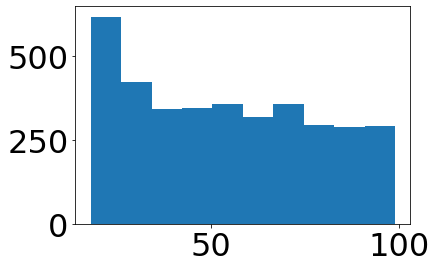

In [607]:
plt.hist(ecg_y_k)

In [608]:
ecg_X_k.shape

(3642, 60000, 1)

In [429]:
#To get only lead I
ecg_X_k = ecg_X_k[:, 0:5000, :]

In [4]:
#To get 2D array for 12-lead ecgs
ecg_X_k = ecg_X_k.reshape(ecg_X_k.shape[0], 12, int(ecg_X_k.shape[1]/12), ecg_X_k.shape[2])

In [430]:
ecg_X_k = ecg_X_k.reshape(ecg_X_k.shape[0], ecg_X_k.shape[1])   #removes last dimension

In [431]:
ecg_X_rescaled = np.zeros((ecg_X_k.shape))

In [432]:
for ecgnum in range(ecg_X_k.shape[0]):            #normalizes with mean 0 and max 1
    ecg_X_rescaled[ecgnum] = ecg_X_k[ecgnum]-np.mean(ecg_X_k[ecgnum])
    ecg_X_rescaled[ecgnum] = ecg_X_rescaled[ecgnum]/np.max(ecg_X_rescaled[ecgnum])


/home/jjohn2/miniconda3/envs/ehr_classification/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [595]:
skipped1 = []
skipped2 = []
skipped3 = []
ecg_X_full_intervals = np.zeros((0, 6))
ecg_X_intervals = np.zeros((0, 6))

for ecg_num in range(ecg_X_rescaled.shape[0]):
    peaks, _ = find_peaks(ecg_X_rescaled[ecg_num], distance = 150, prominence=0.6)
    
    if (len(peaks)>=7):
        if (peaks[6]-peaks[0]>= 1500) & (peaks[6]-peaks[0]<=4500):  #selects mean HR 40-120 for the 7 beats
        
            #finds R-R intervals, as the percentage of the 7 beat group for each R-R interval
            rr_ints = [(t - s)/(peaks[6]-peaks[0]) for s, t in zip(peaks[0:6], peaks[1:7])] 
            rr_full = [(t - s) for s, t in zip(peaks[0:6], peaks[1:7])] 
        
            ecg_X_full_intervals = np.concatenate((ecg_X_full_intervals, np.array([rr_full])))
            ecg_X_intervals = np.concatenate((ecg_X_intervals, np.array([rr_ints])))
        else: 
            if (peaks[6]-peaks[0]< 1500):
                skipped1.append(ecg_num)
            if (peaks[6]-peaks[0]>4500):
                skipped2.append(ecg_num)
    else:
        skipped3.append(ecg_num)                

In [582]:
len(skipped1)       # 614 skipped for detected mean HR for first 7 beats >120 (oversensing t-wave?)

614

In [583]:
len(skipped2)       # 11 skipped for detected mean HR for first 7 beats <40

11

In [584]:
len(skipped3)       # 284 skipped for not having at least 7 beats detected

284

In [585]:
skipped = skipped1 + skipped2 + skipped3

In [586]:
len(skipped)        # 909

909

In [587]:
ecg_X_intervals.shape   #26,306 kept

(26306, 6)

In [596]:
ecg_X_full_intervals.shape

(26306, 6)

In [594]:
ecg_X_intervals

array([[0.28893587, 0.14446794, 0.14270613, 0.14200141, 0.14164905,
        0.14023961],
       [0.15200722, 0.17095174, 0.1736581 , 0.17861976, 0.1691475 ,
        0.1556157 ],
       [0.16314779, 0.14747281, 0.16666667, 0.1753039 , 0.17914267,
        0.16826615],
       ...,
       [0.11697927, 0.17176703, 0.17472853, 0.17472853, 0.17917078,
        0.18262586],
       [0.17140059, 0.16601371, 0.16797258, 0.16895201, 0.16895201,
        0.15670911],
       [0.17895204, 0.17984014, 0.17717584, 0.17761989, 0.17806394,
        0.10834813]])

In [597]:
ecg_X_full_intervals

array([[820., 410., 405., 403., 402., 398.],
       [337., 379., 385., 396., 375., 345.],
       [510., 461., 521., 548., 560., 526.],
       ...,
       [237., 348., 354., 354., 363., 370.],
       [350., 339., 343., 345., 345., 320.],
       [403., 405., 399., 400., 401., 244.]])

In [588]:
mask = np.ones_like(ecg_y_k, bool)

In [589]:
mask[skipped]=False

In [590]:
ecg_y_intervals = ecg_y_k[mask]       #26,306 in y numpy array
print(ecg_y_intervals.shape)

(26306,)


In [459]:
np.mean(ecg_X_intervals)  #0.167

0.16666666666666666

In [460]:
np.max(ecg_X_intervals)   #0.509

0.5088401697312589

In [461]:
np.min(ecg_X_intervals)   #0.042

0.04211994421199442

In [462]:
ecg_X_intervals_all = ecg_X_intervals.flatten()

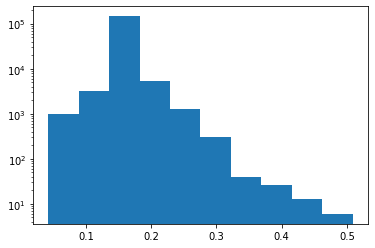

In [463]:
plt.hist(ecg_X_intervals_all)
plt.yscale('log')

In [464]:
#will set min and max R-R intervals to avoid PACs and PVCs
#mean R-R: 0.1667
#max- 0.200 : 20% increase
#min- 0.133 : 20% decrease
#difference between min and max- 50%
ecg_y_intervals = ecg_y_intervals[(np.min(ecg_X_intervals, axis=1)>=0.133) & (np.max(ecg_X_intervals, axis=1)<=0.2)]
ecg_X_intervals = ecg_X_intervals[(np.min(ecg_X_intervals, axis=1)>=0.133) & (np.max(ecg_X_intervals, axis=1)<=0.2),:]

print(ecg_X_intervals.shape)    #23,509 of 26,306 remaining; will use 2,000 for val set
print(ecg_y_intervals.shape)

(23509, 6)
(23509,)


In [598]:
ecg_X_full_intervals = ecg_X_full_intervals[(np.min(ecg_X_intervals, axis=1)>=0.133) & (np.max(ecg_X_intervals, axis=1)<=0.2),:]


In [599]:
ecg_X_full_intervals.shape

(23509, 6)

In [601]:
X_train_full_list = [0]
X_train_full_list[0] = ecg_X_full_intervals[0:21509]

In [129]:
#alternative to k-fold   [ ] look into

X_train_list = [0]
y_train_list = [0]
X_val_list = [0]
y_val_list = [0]

X_train_list[0] = ecg_X_intervals[0:24090]
y_train_list[0] = ecg_y_intervals[0:24090]

X_val_list[0] = ecg_X_intervals[24090:]
y_val_list[0] = ecg_y_intervals[24090:]

NameError: name 'ecg_X_intervals' is not defined

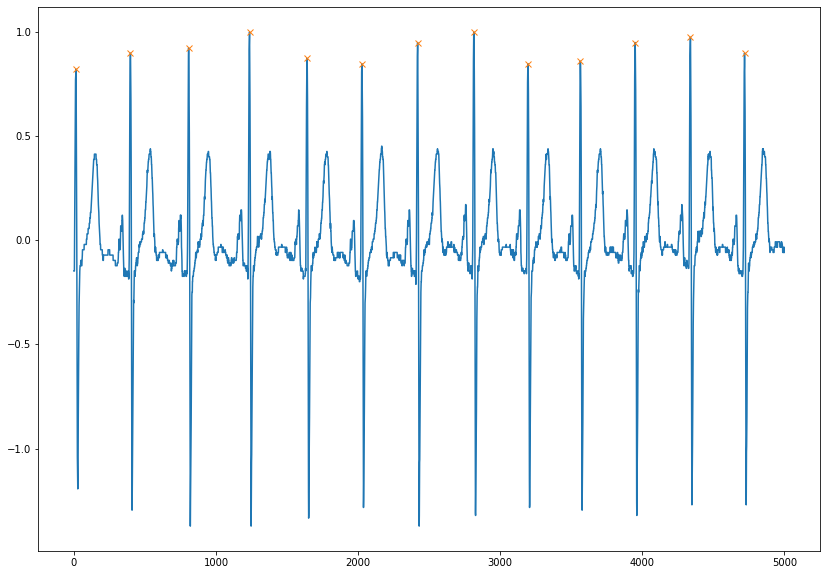

In [316]:
#to visualize ECGs
ecg_num= 108

peaks, _ = find_peaks(ecg_X_rescaled[ecg_num], distance = 150, prominence=0.6) 

plt.figure(figsize=(14,10))
plt.plot(ecg_X_rescaled[ecg_num])
plt.plot(peaks, ecg_X_rescaled[ecg_num][peaks], 'x')

In [465]:
X_train_list = [0]
y_train_list = [0]
X_val_list = [0]
y_val_list = [0]

X_train_list[0] = ecg_X_k[0:21509]
y_train_list[0] = ecg_y_k[0:21509]

X_val_list[0] = ecg_X_k[21509:]
y_val_list[0] = ecg_y_k[21509:]

In [138]:

X_train_list = [0]
y_train_list = [0]
X_val_list = [0]
y_val_list = [0]
meta_df_train_list = [0]
meta_df_val_list = [0]

X_train_list[0] = ecg_X_k[0:24090]
y_train_list[0] = ecg_y_k[0:24090]
meta_df_train_list[0] = meta_df_set[0:24090]

X_val_list[0] = ecg_X_k[24090:]
y_val_list[0] = ecg_y_k[24090:]
meta_df_val_list[0] = meta_df_set[24090:]

In [143]:
X_train_list[0].shape

(24090, 5000, 1)

In [142]:
X_train_list[0] = X_train_list[0][:, 0:5000, :]

In [144]:
X_val_list[0] = X_val_list[0][:, 0:5000, :]

In [145]:
y_val_list[0].shape

(3000, 5000, 1)

(3000, 10)

In [468]:
np.unique(y_val_list)

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100])

In [ ]:
#if reshaping needed
X_train_list[0] = X_train_list[0].reshape(X_train_list[0].shape[0], 12, 5000, 1)
X_val_list[0] = X_val_list[0].reshape(X_val_list[0].shape[0], 12, 5000, 1)

In [ ]:
X_val_list[0][0][0:10]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(X_val_list[0][45][0:500])

In [146]:
class corr_checkpointer(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, filepath, batch_size=512, **kwargs):
        super().__init__(**kwargs)
        self.x_val = x_val
        self.y_val = y_val
        self.best_corr = -1.
        self.curr_corr = 0.0
        self.best_epoch = 0
        self.batch_size = batch_size
        self.filepath = filepath
    
    def on_epoch_end(self, epoch, logs={}):
        print('\nBest Pearson: %.3f, from epoch %d' % (self.best_corr, self.best_epoch))
        pred_val = self.model.predict(self.x_val, batch_size=self.batch_size)
        pred_val = pred_val.reshape(pred_val.shape[0])
        pearson_val = stats.pearsonr(pred_val, self.y_val)
        print('Current Pearson: %.3f' % pearson_val[0])
        
        if(pearson_val[0] > self.best_corr):
            self.best_corr = pearson_val[0]
            self.best_epoch = epoch + 1
            self.model.save(self.filepath, overwrite=True)
            print('Saved current epoch model')       
    

In [147]:
class corr_early_stopping(keras.callbacks.EarlyStopping):
    def __init__(self, min_epochs=200, **kwargs):
        super().__init__(**kwargs)
        self.min_epochs = min_epochs
    
    def on_epoch_end(self, epoch, logs=None):   #parent function with alterations as below
        current = corr_check.best_corr          #change value assigned to current
        if current is None:
            return
        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if (self.wait >= self.patience) and (epoch > self.min_epochs):   #add min_epochs
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of the best epoch.')
                    self.model.set_weights(self.best_weights)

In [148]:
#from https://www.jeremyjordan.me/nn-learning-rate/

class LRFinder(keras.callbacks.Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [149]:
#from https://github.com/psklight/keras_one_cycle_clr/blob/master/keras_one_cycle_clr/one_cycle.py

class OneCycle(keras.callbacks.Callback):
    """
    A callback class for one-cycle policy training.
    :param lr_range: a tuple of starting (usually minimum) lr value and maximum (peak) lr value.
    :param momentum_range: a tuple of momentum values.
    :param phase_one_fraction: a fraction for phase I (increasing lr) in one cycle. Must between 0 to 1.
    :param reset_on_train_begin: True or False to reset counters when training begins.
    :param record_frq: integer > 0, a frequency in batches to record training loss.
    :param verbose: True or False to print progress.
    """

    def __init__(
            self,
            lr_range,
            momentum_range=None,
            phase_one_fraction=0.3,
            reset_on_train_begin=True,
            record_frq=10,
            verbose=False):

        super(OneCycle, self).__init__()

        self.lr_range = lr_range

        self.momentum_range = momentum_range
        if momentum_range is not None:
            err_msg = "momentum_range must be a 2-numeric tuple (m1, m2)."
            if not isinstance(momentum_range, (tuple,)) or len(momentum_range) != 2:
                raise ValueError(err_msg)

        self.phase_one_fraction = phase_one_fraction
        self.reset_on_train_begin = reset_on_train_begin
        self.record_frq = record_frq
        self.verbose = verbose

        # helper tracker
        self.log = {}  # history in iterations
        self.log_ep = {}  # history in epochs
        self.stop_training = False

        # counter
        self.current_iter = 0

    def get_current_lr(self, n_iter=None):
        """
        A helper function to calculate a current learning rate based on current iteration number.
        :return lr: a current learning rate.
        """
        if n_iter is None:
            n_iter = self.n_iter

        x = float(self.current_iter) / n_iter
        if x < self.phase_one_fraction:
            amp = self.lr_range[1] - self.lr_range[0]
            lr = (np.cos(x * np.pi/self.phase_one_fraction - np.pi) + 1) * amp / 2.0 + self.lr_range[0]
        if x >= self.phase_one_fraction:
            amp = self.lr_range[1]
            lr = (np.cos((x - self.phase_one_fraction) * np.pi/ (1-self.phase_one_fraction)) + 1) / 2.0 * amp
        return lr

    def get_current_momentum(self, n_iter=None):
        """
        A helper function to calculate a current momentum based on current iteration number.
        :return momentum: a current momentum.
        """
        if n_iter is None:
            n_iter = self.n_iter
        amp = self.momentum_range[1] - self.momentum_range[0]
        # delta = (1 - np.abs(np.mod(self.current_iter, n_iter) * 2.0 / n_iter - 1)) * amplitude
        x = float(self.current_iter) / n_iter
        if x < self.phase_one_fraction:
            delta = (np.cos(x * np.pi / self.phase_one_fraction - np.pi) + 1) * amp / 2.0
        if x >= self.phase_one_fraction:
            delta = (np.cos((x - self.phase_one_fraction) * np.pi / (1 - self.phase_one_fraction)) + 1) / 2.0 * amp
        return delta + self.momentum_range[0]


    @property
    def cycle_momentum(self):
        return self.momentum_range is not None

    def on_train_begin(self, logs={}):
        self.n_epoch = self.params['epochs']

        # find number of batches per epoch
        if self.params['batch_size'] is not None:  # model.fit
            self.n_bpe = int(np.ceil(self.params['samples'] / self.params['batch_size']))
        if self.params['batch_size'] is None:  # model.fit_generator
            self.n_bpe = self.params['samples']

        self.n_iter = self.n_epoch * self.n_bpe
        # this is a number of iteration in one cycle

        self.current_iter = 0

    def on_train_batch_begin(self, batch, logs={}):
        set_lr(self.model.optimizer, self.get_current_lr())
        if self.cycle_momentum:
            set_momentum(self.model.optimizer, self.get_current_momentum())

    def on_train_batch_end(self, batch, logs={}):

        if self.verbose:
            print("lr={:.2e}".format(self.get_current_lr()), ",", "m={:.2e}".format(self.get_current_momentum()))

        # record according to record_frq
        if np.mod(int(self.current_iter), self.record_frq) == 0:
            self.log.setdefault('lr', []).append(self.get_current_lr())
            if self.cycle_momentum:
                self.log.setdefault('momentum', []).append(self.get_current_momentum())

            for k, v in logs.items():
                self.log.setdefault(k, []).append(v)

            self.log.setdefault('iter', []).append(self.current_iter)

        # update current iteration
        self.current_iter += 1

        # consider termination
        if self.current_iter == self.n_iter:
            self.stop_training = True

    def on_epoch_end(self, epoch, logs={}):
        self.log_ep.setdefault('epoch', []).append(epoch)
        self.log_ep.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))

        for k, v in logs.items():
            self.log_ep.setdefault(k, []).append(v)

    def test_run(self, n_iter=None):
        """
        Visualize values of learning rate (and momentum) as a function of iteration (batch).
        :param n_iter: a number of cycles. If None, 1000 is used.
        """

        if hasattr(self, 'current_iter'):
            original_it = self.current_iter

        if n_iter is None:
            if hasattr(self, 'n_iter'):
                n_iter = self.n_iter
            else:
                n_iter = 1000
        n_iter = int(n_iter)

        lrs = np.zeros(shape=(n_iter,))
        if self.momentum_range is not None:
            moms = np.zeros_like(lrs)

        for i in range(int(n_iter)):
            self.current_iter = i
            lrs[i] = self.get_current_lr(n_iter)
            if self.cycle_momentum:
                moms[i] = self.get_current_momentum(n_iter)
        if not self.cycle_momentum:
            plt.plot(lrs)
            plt.xlabel('iterations')
            plt.ylabel('lr')
        else:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(lrs)
            plt.xlabel('iterations')
            plt.ylabel('lr')
            plt.subplot(1, 2, 2)
            plt.plot(moms)
            plt.xlabel('iterations')
            plt.ylabel('momentum')

        if hasattr(self, 'current_iter'):
            self.current_iter = original_it

def set_momentum(optimizer, mom_val):
    """
    Helper to set momentum of Keras optimizers.
    :param optimizer: Keras optimizer
    :param mom_val: value of momentum.
    """
    keys = dir(optimizer)
    if "momentum" in keys:
        K.set_value(optimizer.momentum, mom_val)
    if "rho" in keys:
        K.set_value(optimizer.rho, mom_val)
    if "beta_1" in keys:
        K.set_value(optimizer.beta_1, mom_val)


def set_lr(optimizer, lr):
    """
    Helper to set learning rate of Keras optimizers.
    :param optimizer: Keras optimizer
    :param lr: value of learning rate.
    """
    K.set_value(optimizer.lr, lr)

In [150]:
#adapted version of https://github.com/josesho/bland_altman/blob/master/bland_altman.py

def bland_altman_plot(m1, m2,
                      sd_limit=1.96,
                      ax=None,
                      scatter_kwds=None,
                      mean_line_kwds=None,
                      limit_lines_kwds=None,
                      title=None):


    import numpy as np
    import matplotlib.pyplot as plt

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    if ax is None:
        plt.figure(figsize=(10,5))
        ax = plt.gca()
        ax.set_title(title, fontsize=14)
        

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'

    ax.scatter(means, diffs, **scatter_kwds, alpha=0.3)
    ax.axhline(mean_diff, **mean_line_kwds)  # draw mean line.

    # Annotate mean line with mean difference.
    ax.annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                xy=(0.99, 0.49),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=12,
                xycoords='axes fraction')

    if sd_limit > 0:
        plt.axis('scaled')
        left, right = plt.xlim()
        plt.xlim(left*0.7, right*1.2)
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - (half_ylim*2),
                    mean_diff + (half_ylim*2))
        
        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        ax.annotate('-SD{}: {}'.format(sd_limit, np.round(lower, 2)),
                    xy=(0.99, 0.25),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=12,
                    xycoords='axes fraction')
        ax.annotate('+SD{}: {}'.format(sd_limit, np.round(upper, 2)),
                    xy=(0.99, 0.70),
                    horizontalalignment='right',
                    fontsize=12,
                    xycoords='axes fraction')

    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    ax.set_ylabel('Difference', fontsize=12)
    ax.set_xlabel('Means', fontsize=12)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    return ax


In [ ]:
X_train_list[0] = ecg_X_k[0:24090]
y_train_list[0] = ecg_y_k[0:24090]
meta_df_train_list[0] = meta_df_set[0:24090]

In [156]:
meta_df_train_list[0].head()

,VentricularRate,PRInterval,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QOnset,QOffset,TOffset
0,75,176,88,394,439,53,39,446,534,840
6,82,130,106,394,460,44,38,432,538,826
9,58,126,80,376,369,60,23,440,520,816
12,93,112,86,342,425,54,60,440,526,782
14,65,150,92,422,438,53,37,434,526,856


In [158]:
meta_df_train = meta_df_train_list[0].to_numpy()

In [161]:
meta_df_val = meta_df_val_list[0].to_numpy()

In [162]:
meta_df_val.shape

(3000, 10)

In [151]:
suffix = 'ecg_meaurements_age_05_27_2020'

In [152]:
K.clear_session()
filename_base = 'trained_' + suffix + '_1'
print(filename_base)

trained_ecg_meaurements_age_05_27_2020_1


In [203]:
#based on Wavenet

inputs = Input((5000, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

c1 = Conv1D(32,8, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
#c2 = MaxPooling1D(pool_size=1, strides=4) (c2)

c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=8, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=16, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(10) (final)

In [196]:
#only Dense layers

inputs = Input((5000, 1))

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (inputs)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

c1 = Dense(5, kernel_initializer = 'he_normal', activation = 'relu') (c1)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.5) (c1)

outputs = Dense(10) (c1)

#c1 = Conv2D(32,(1,8), padding='same', strides=(1,2), use_bias = False, kernel_initializer= 'he_normal') (c1)
#c1 = BatchNormalization() (c1)
#c1 = Activation('relu') (c1)
#c1 = Dropout(0.1) (c1)

In [207]:
#changed to Adam, changed batch size

set_loss = 'mean_squared_error'       # 'binary_crossentropy'    #'mean_squared_error'
set_metrics = ['mean_squared_error']  # ['accuracy']             #['mean_squared_error']

num_batch_size=256   #180
num_epochs=10000
num_patience=300
stopping_min_epochs=80
weight_d = 0 #0.000001  

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
model.save_weights('temp.h5')

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 2500, 32)     256         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 2500, 32)     128         conv1d_17[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 2500, 32)     0           batch_normalization_72[0][0]     
___________________________________________________________________________________________

Train on 24090 samples
24090/24090 [==============================] - 22s 900us/sample - loss: 9949.1756 - mean_squared_error: 9949.1748


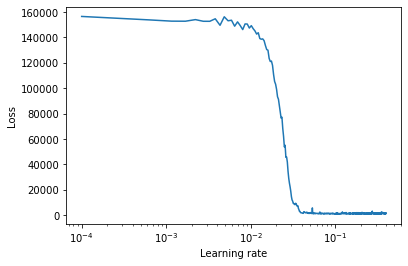

In [202]:
#lr_finder = LRFinder(min_lr=1e-4, max_lr=1e-1, steps_per_epoch=np.ceil(X_train_list[0].shape[0]/num_batch_size), epochs=1)

#model.fit(X_train_list[0], meta_df_train, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [208]:
i=0
#corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
#early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)

history = model.fit(X_train_list[0], meta_df_train, validation_data = (X_val_list[0], meta_df_val), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])  


Train on 24090 samples, validate on 3000 samples
Epoch 1/10000
24064/24090 [============================>.] - ETA: 0s - loss: 29610.4261 - mean_squared_error: 29610.4258
Epoch 00001: val_mean_squared_error improved from inf to 32121.16602, saving model to trained_ecg_meaurements_age_05_27_2020_1_fold_0.h5
24090/24090 [==============================] - 15s 635us/sample - loss: 29603.5168 - mean_squared_error: 29603.5176 - val_loss: 32121.1630 - val_mean_squared_error: 32121.1660
Epoch 2/10000
24064/24090 [============================>.] - ETA: 0s - loss: 19177.9734 - mean_squared_error: 19177.9707
Epoch 00002: val_mean_squared_error improved from 32121.16602 to 19738.28320, saving model to trained_ecg_meaurements_age_05_27_2020_1_fold_0.h5
24090/24090 [==============================] - 12s 479us/sample - loss: 19174.4237 - mean_squared_error: 19174.4219 - val_loss: 19738.2826 - val_mean_squared_error: 19738.2832
Epoch 3/10000
24064/24090 [============================>.] - ETA: 0s - loss

Epoch 42/10000
24064/24090 [============================>.] - ETA: 0s - loss: 1004.6121 - mean_squared_error: 1004.6118
Epoch 00042: val_mean_squared_error did not improve from 756.96765
24090/24090 [==============================] - 11s 473us/sample - loss: 1004.7967 - mean_squared_error: 1004.7963 - val_loss: 768.6549 - val_mean_squared_error: 768.6548
Epoch 43/10000
24064/24090 [============================>.] - ETA: 0s - loss: 1004.4927 - mean_squared_error: 1004.4929
Epoch 00043: val_mean_squared_error improved from 756.96765 to 755.49597, saving model to trained_ecg_meaurements_age_05_27_2020_1_fold_0.h5
24090/24090 [==============================] - 12s 480us/sample - loss: 1004.4391 - mean_squared_error: 1004.4393 - val_loss: 755.4960 - val_mean_squared_error: 755.4960
Epoch 44/10000
24064/24090 [============================>.] - ETA: 0s - loss: 1001.4204 - mean_squared_error: 1001.4207
Epoch 00044: val_mean_squared_error improved from 755.49597 to 752.82135, saving model to tr

Epoch 85/10000
24064/24090 [============================>.] - ETA: 0s - loss: 919.7887 - mean_squared_error: 919.7888
Epoch 00085: val_mean_squared_error did not improve from 666.14459
24090/24090 [==============================] - 11s 473us/sample - loss: 919.6744 - mean_squared_error: 919.6745 - val_loss: 685.1158 - val_mean_squared_error: 685.1158
Epoch 86/10000
24064/24090 [============================>.] - ETA: 0s - loss: 916.9209 - mean_squared_error: 916.9207
Epoch 00086: val_mean_squared_error did not improve from 666.14459
24090/24090 [==============================] - 11s 471us/sample - loss: 916.8903 - mean_squared_error: 916.8900 - val_loss: 679.5806 - val_mean_squared_error: 679.5806
Epoch 87/10000
24064/24090 [============================>.] - ETA: 0s - loss: 919.7486 - mean_squared_error: 919.7486
Epoch 00087: val_mean_squared_error did not improve from 666.14459
24090/24090 [==============================] - 11s 470us/sample - loss: 919.3790 - mean_squared_error: 919.37

KeyboardInterrupt: 

In [ ]:
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})

preds_val = model.predict(X_val_list[0], verbose=1, batch_size=256)
preds_val = preds_val.reshape(preds_val.shape[0])
    
    #****
#y_val_list_scaled = y_val_list[0]
#preds_val = preds_val_initial

y_val_list_scaled = meta_df_val
#y_val_list_scaled = y_val_list[0] #np.divide((y_val_list_scaled), 4)
#preds_val = np.divide((preds_val_initial), 4)
    
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

spearman = stats.spearmanr(preds_val, y_val_list_scaled)
#pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
print(spearman)
print(mean_ae)
print(median_ae)

In [211]:
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})

preds_val = model.predict(X_val_list[0], verbose=1, batch_size=256)
#preds_val = preds_val.reshape(preds_val.shape[0])
    
    #****
#y_val_list_scaled = y_val_list[0]
#preds_val = preds_val_initial

y_val_list_scaled = meta_df_val
#y_val_list_scaled = y_val_list[0] #np.divide((y_val_list_scaled), 4)
#preds_val = np.divide((preds_val_initial), 4)
    
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18
    

for preds_val_single, y_val_single in preds_val, y_val_list_scaled:
    spearman = stats.spearmanr(preds_val_single, y_val_list_single)
    #pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    mean_ae = np.mean(abs(preds_val_single - y_val_list_scaled))
    median_ae = np.median(abs(preds_val_single - y_val_list_scaled))
    
    print(spearman)
    print(mean_ae)
    print(median_ae)

3000/3000 [==============================] - 1s 329us/sample


ValueError: too many values to unpack (expected 2)

In [210]:
preds_val.shape

(3000, 10)

In [212]:
preds_val

array([[ 70.5455  , 159.63031 ,  90.34383 , ..., 432.4726  , 522.5986  ,
        827.9529  ],
       [ 73.089836, 159.57451 ,  90.65941 , ..., 438.21927 , 529.00665 ,
        833.9741  ],
       [ 84.63238 , 151.86603 ,  88.111115, ..., 433.47665 , 521.57263 ,
        802.4389  ],
       ...,
       [ 78.23346 , 154.6442  ,  89.00816 , ..., 433.58374 , 522.36487 ,
        814.3645  ],
       [ 85.92109 , 152.28352 ,  88.508316, ..., 437.94394 , 526.38605 ,
        807.3736  ],
       [ 76.76708 , 153.54099 ,  88.237656, ..., 427.05328 , 515.2489  ,
        802.99695 ]], dtype=float32)

In [224]:
for i in range(10):
    
#for preds_val_single, y_val_single in preds_val, y_val_list_scaled:
    spearman = stats.spearmanr(preds_val[:,i], y_val_list_scaled[:,i])
    #pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    #mean_ae = np.mean(abs(preds_val_single - y_val_list_scaled))
    #median_ae = np.median(abs(preds_val_single - y_val_list_scaled))
    
    print(spearman)
    #print(pearson)
    #print(mean_ae)
    #print(median_ae)

SpearmanrResult(correlation=0.7462495621175274, pvalue=0.0)
SpearmanrResult(correlation=0.30558364737218224, pvalue=7.186224845210927e-66)
SpearmanrResult(correlation=0.2727481000610325, pvalue=2.5147737315167284e-52)
SpearmanrResult(correlation=0.8742538111414241, pvalue=0.0)
SpearmanrResult(correlation=0.3524896240162534, pvalue=1.753709924268579e-88)
SpearmanrResult(correlation=0.19265370811863317, pvalue=1.789720643246854e-26)
SpearmanrResult(correlation=0.047037203205261544, pvalue=0.009975245328257798)
SpearmanrResult(correlation=-0.07841533071213037, pvalue=1.709395426611738e-05)
SpearmanrResult(correlation=0.20552743256408018, pvalue=5.625288641593203e-30)
SpearmanrResult(correlation=0.8775152896639844, pvalue=0.0)


In [ ]:
['VentricularRate', 'PRInterval', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QOnset', 'QOffset', 'TOffset']

In [215]:
for i in range(10):
    print(preds_val[i])

[ 70.5455   159.63031   90.34383  396.25742  424.96268   25.850073
  41.368073 432.4726   522.5986   827.9529  ]
[ 73.089836 159.57451   90.65941  397.00735  431.5334    28.148552
  41.545673 438.21927  529.00665  833.9741  ]
[ 84.63238  151.86603   88.111115 367.9269   429.72263   32.591988
  41.875584 433.47665  521.57263  802.4389  ]
[ 93.326065 160.06387   92.686104 384.25677  459.1827    37.48302
  45.0528   463.25693  555.8226   848.0757  ]
[ 61.43446 165.24086  91.82118 419.6901  423.95657  22.91973  41.57112
 435.31796 527.0897  854.29584]
[ 67.81478  159.62303   89.89135  397.3923   421.1362    24.600266
  43.000828 429.7824   519.7672   826.54614 ]
[ 78.825066 155.81471   89.31625  380.0006   428.06006   30.07986
  41.07771  434.4059   523.5676   813.7077  ]
[ 83.81378  161.09341   92.67841  394.36813  447.43295   31.787226
  44.66882  454.8277   547.5014   850.415   ]
[ 90.97593  141.49843   82.787094 334.6872   415.98203   37.37433
  40.07708  419.48267  502.1495   755.8509

In [220]:
preds_val[1,1]

159.57451

In [214]:
preds_val

array([[ 70.5455  , 159.63031 ,  90.34383 , ..., 432.4726  , 522.5986  ,
        827.9529  ],
       [ 73.089836, 159.57451 ,  90.65941 , ..., 438.21927 , 529.00665 ,
        833.9741  ],
       [ 84.63238 , 151.86603 ,  88.111115, ..., 433.47665 , 521.57263 ,
        802.4389  ],
       ...,
       [ 78.23346 , 154.6442  ,  89.00816 , ..., 433.58374 , 522.36487 ,
        814.3645  ],
       [ 85.92109 , 152.28352 ,  88.508316, ..., 437.94394 , 526.38605 ,
        807.3736  ],
       [ 76.76708 , 153.54099 ,  88.237656, ..., 427.05328 , 515.2489  ,
        802.99695 ]], dtype=float32)

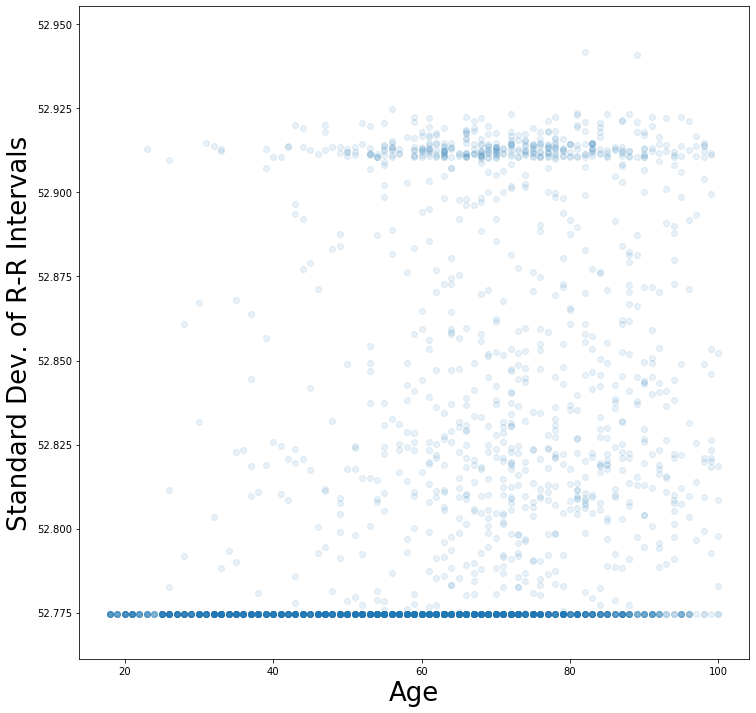

In [173]:
fig, ax = plt.subplots(figsize=(12,12)) 
plt.scatter(y_val_list_scaled, preds_val, alpha=0.1)
    
#ax.set_title('Age Using MGH 12-Lead ECGs', fontsize=28)

#ax.set(xlim = [0, 105], ylim = [0, 105])
#plt.xticks(range(0, 105, 10), fontsize=20)
#plt.yticks(range(0, 105, 10), fontsize=20)
plt.xlabel('Age', fontsize=26)
plt.ylabel('Standard Dev. of R-R Intervals', fontsize=26)

#ax.plot([0, 105], [0,105], alpha=0.2)
plt.show()

In [571]:
X_interval_std = np.std(X_train_list[0], axis=1)

In [602]:
X_interval_full_std = np.std(X_train_full_list[0], axis=1)

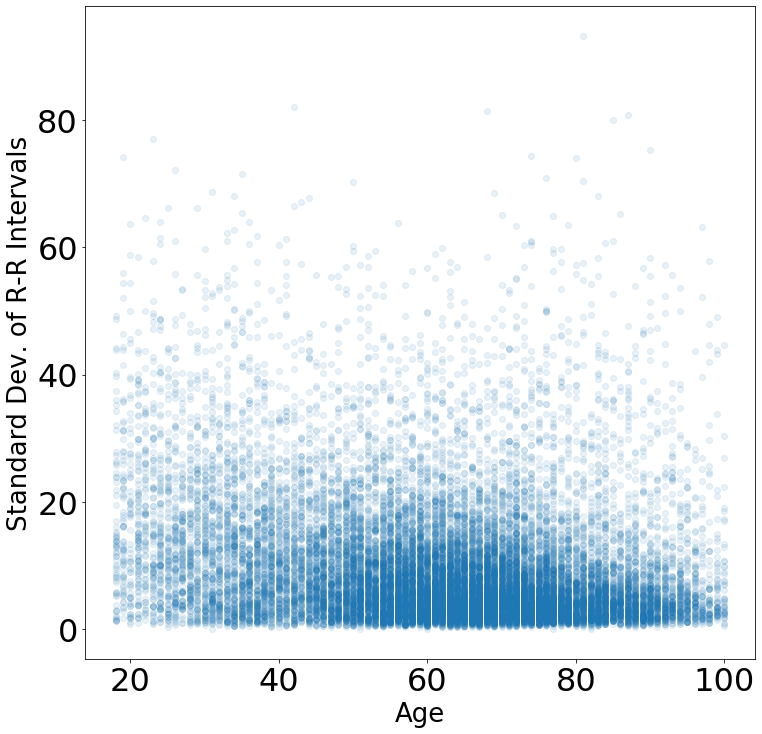

In [604]:


fig, ax = plt.subplots(figsize=(12,12)) 
plt.scatter(y_train_list[0], X_interval_full_std, alpha=0.1)
    
#ax.set_title('Age Using MGH 12-Lead ECGs', fontsize=28)

#ax.set(xlim = [0, 105], ylim = [0, 105])
#plt.xticks(range(0, 105, 10), fontsize=20)
#plt.yticks(range(0, 105, 10), fontsize=20)
plt.xlabel('Age', fontsize=26)
plt.ylabel('Standard Dev. of R-R Intervals', fontsize=26)

#ax.plot([0, 105], [0,105], alpha=0.2)
plt.show()

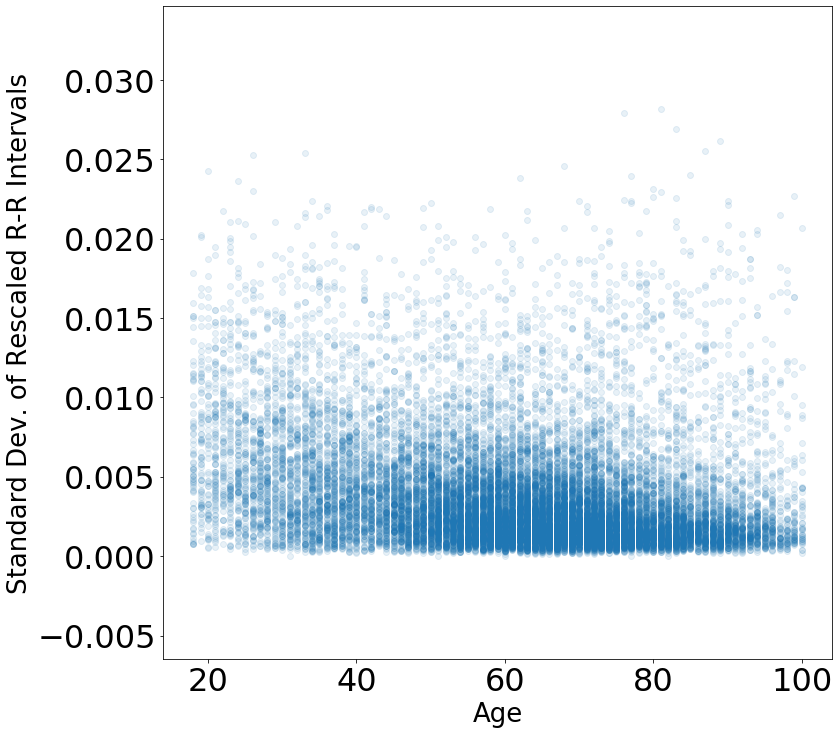

In [580]:


fig, ax = plt.subplots(figsize=(12,12)) 
plt.scatter(y_train_list[0], X_interval_std, alpha=0.1)
    
#ax.set_title('Age Using MGH 12-Lead ECGs', fontsize=28)

#ax.set(xlim = [0, 105], ylim = [0, 105])
#plt.xticks(range(0, 105, 10), fontsize=20)
#plt.yticks(range(0, 105, 10), fontsize=20)
plt.xlabel('Age', fontsize=26)
plt.ylabel('Standard Dev. of Rescaled R-R Intervals', fontsize=26)

#ax.plot([0, 105], [0,105], alpha=0.2)
plt.show()

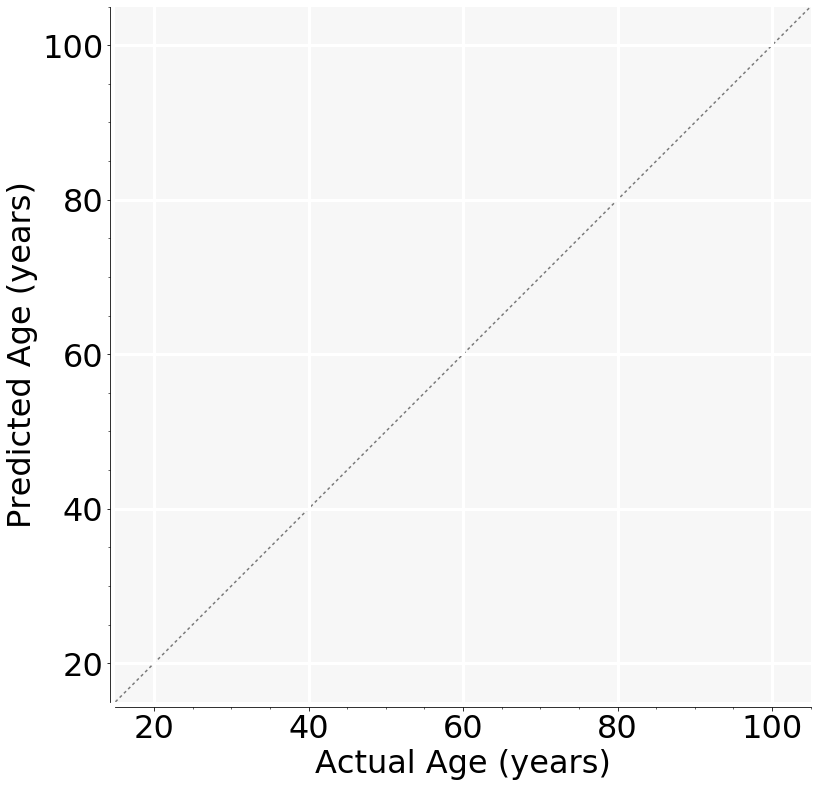

In [561]:
#for age

#for PR, range 60-420
#for age, range 15-105
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(y_val_list_scaled, preds_val, color='#732673', alpha = 0.3)
lims = [15, 105]
    #np.min([60, 60]),  # min of both axes
    #np.max([420, 420]),  # max of both axes

ax.plot(lims, lims, alpha=0.75, zorder=0, color='#505050', linestyle='--', dashes = [2,2])
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.set_xlim([-0.02, 1.0])
#ax.set_ylim([-0.02, 1.05])
#ax.set_title('PR Interval Using AMC Single-Lead ECGs', fontsize=34)
ax.set_xlabel('Actual Age (years)')
ax.set_ylabel('Predicted Age (years)')
ax.set_facecolor('#f7f7f7')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
#ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
#ax.legend(loc='best', frameon=False)
plt.yticks(np.arange(20, 110, 20))
plt.minorticks_on()
plt.tight_layout()
plt.rcParams.update({'font.size': 32})
plt.show()
#outfile = "test.png"
#fig.savefig(outfile)
#plt.close(fig)

In [510]:
preds_val

array([56.76424 , 55.425697, 57.929504, ..., 58.189243, 57.459213,
       56.499126], dtype=float32)

In [507]:
y_val_list_scaled

array([44, 49, 63, ..., 57, 53, 31])

In [ ]:
#Regression (binary classification separate)
#suffix = 'sex_8k'
#suffix = 'pr_12lead_2d'

In [ ]:
#suffix = 'corrected_60k_age_12lead'

In [ ]:
suffix

In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_1'
print(filename_base)

in_neurons=5000

In [ ]:
#12-lead model
inputs = Input((12, in_neurons, 1))

c1 = Conv2D(16,(1,4), padding='same', strides=(1,2), use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

c1 = Conv2D(32,(1,8), padding='same', strides=(1,2), use_bias = False, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv2D(16, (1,8), padding='same', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv2D(32,(1,8), padding='same', dilation_rate=(1,2), kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout2D(0.1) (c2)
c2 = WeightNormalization(Conv2D(32,(1,8), padding='same', dilation_rate=(1,4), kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout2D(0.1) (c2)
#c2 = MaxPooling1D(pool_size=1, strides=4) (c2)

c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=(1,8), kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout2D(0.1) (c3)
c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=(1,16), kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout2D(0.1) (c3)
c3 = MaxPooling2D(pool_size=1, strides=(1,8)) (c3)

c7 = Conv2D(8, (1,3), use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

c7 = Conv2D(16, (12,1), use_bias=False, kernel_initializer='he_normal') (c7)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
#single-lead model

inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

c1 = Conv1D(32,8, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
#c2 = MaxPooling1D(pool_size=1, strides=4) (c2)

c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=8, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=16, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
#changed to Adam, changed batch size

set_loss = 'mean_squared_error' # 'binary_crossentropy'    #'mean_squared_error'
set_metrics = ['mean_squared_error']  # ['accuracy']                      #['mean_squared_error']

num_batch_size=512   #180
num_epochs=100
num_patience=30
stopping_min_epochs=80
weight_d = 0 #0.000001  

#adamw = AdamW(weight_decay=weight_d)
adam = optimizers.Adam()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adam, loss = set_loss, metrics= set_metrics)
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i = 0
#y_train_list_scaled = y_train_list[i]
#y_val_list_scaled = y_val_list[i]

In [ ]:
#removed age scaling

#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))

#12-lead- too large
#X_train_list_scaled_a = np.divide(X_train_list[i][0:27000],4000)
#X_train_list_scaled_b = np.divide(X_train_list[i][27000:],4000)
#X_train_list_scaled = np.vstack((X_train_list_scaled_a, X_train_list_scaled_b))


X_train_list_scaled = np.divide(X_train_list[i], 4000)
X_val_list_scaled = np.divide(X_val_list[i], 4000)

y_train_list_scaled = np.multiply((y_train_list[i]), 4)   #for age
y_val_list_scaled = np.multiply((y_val_list[i]), 4)

#padding to replicate Mayo Clinic paper
#X_train_list_scaled = np.pad(X_train_list_scaled, pad_width=((0,0),(0,0),(60,60),(0,0)))
#X_val_list_scaled = np.pad(X_val_list_scaled, pad_width=((0,0),(0,0),(60,60),(0,0)))


#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
X_train_list_scaled.shape

In [ ]:
y_train_list_scaled.shape

In [ ]:
#X_train_list_lr = X_train_list_scaled[0:5000]

In [ ]:
#y_train_list_lr = y_train_list_scaled[0:5000]

In [ ]:
#lr_finder = LRFinder(min_lr=1e-4, max_lr=1e-1, steps_per_epoch=np.ceil(X_train_list_scaled.shape[0]/num_batch_size), epochs=1)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
#changed to Adam

best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation


for j in range(i, (i+1)):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    adam = optimizers.Adam()  #, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.compile(optimizer= adam, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    #model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    
    
    #corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    #early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
    checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
#should be in above loop
#filename_base = 'trained_' + suffix + '_12'
#adamw = AdamW(weight_decay=weight_d)

#best_epoch = len(history.history['val_mean_squared_error']) - num_patience
#mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
#val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
#mse_hist = history.history['mean_squared_error']
#val_mse_hist = history.history['val_mean_squared_error']


#for round 2 model:
#model = load_model(filename_base + '_fold_' + str(i) + '_round2.h5')
model = load_model(filename_base + '_fold_' + str(i) + '.h5')  #, custom_objects={'AdamW':adamw})

preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=256)
preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
#y_val_list_scaled = y_val_list[0]
#preds_val = preds_val_initial

y_val_list_scaled = y_val_list[i] #np.divide((y_val_list_scaled), 4)
preds_val = np.divide((preds_val_initial), 4)
    
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

spearman = stats.spearmanr(preds_val, y_val_list_scaled)
pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
print(pearson)
print(mean_ae)
print(median_ae)


##best_epochs.append(best_epoch)
#mses.append(mse_model)
##val_mses.append(val_mse_model)
#mse_hists.append(mse_hist)
#val_mse_hists.append(val_mse_hist)
#spearmans.append(spearman)
#pearsons.append(pearson)
#mean_aes.append(mean_ae)
#median_aes.append(median_ae)

In [ ]:

#y_val_list_scaled

In [ ]:
print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()

In [ ]:
plt.plot(mean_mse[50:1000])
plt.plot(mean_val_mse[50:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list_scaled, scatter_kwds={'s':10}, title='Age Using MGH Single-Lead ECGs')



In [ ]:
#for PR, max limit 420, for age 105

fig, ax = plt.subplots(figsize=(12,12)) 
plt.scatter(y_val_list_scaled, preds_val, alpha=0.3)
    
ax.set_title('Age Using MGH 12-Lead ECGs', fontsize=28)

ax.set(xlim = [0, 105], ylim = [0, 105])
plt.xticks(range(0, 105, 10), fontsize=20)
plt.yticks(range(0, 105, 10), fontsize=20)
plt.xlabel('Actual Age', fontsize=26)
plt.ylabel('Predicted Age', fontsize=26)

ax.plot([0, 105], [0,105], alpha=0.2)
plt.show()

In [ ]:
y_val_list_scaled = np.multiply((y_val_list[i]), 4)
model = load_model(filename_base + '_fold_' + str(i) + '.h5')

onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '_round2.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)

history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
y_val_list_scaled

In [ ]:
preds_val_initial

In [16]:
import numpy as np
import pickle
import os
from os import listdir
from os.path import isfile, join
import csv
from skimage.transform import resize
import math
import pandas as pd
from PIL import Image
import PIL
import statistics 
from plotnine import *
from scipy.stats import spearmanr 
from sklearn.linear_model import LinearRegression

In [187]:
y_val_list_scaled

array([67, 32, 89, ..., 60, 31, 58])

In [188]:
y_val_list[0]

array([67, 32, 89, ..., 60, 31, 58])

1815/1815 [==============================] - 2s 1ms/sample
Spearman:  SpearmanrResult(correlation=0.9629803334932744, pvalue=0.0)
Pearson:  (0.9688708189618969, 0.0)
Mean abs error:  4.709776138011417
Median abs error:  3.148406982421875


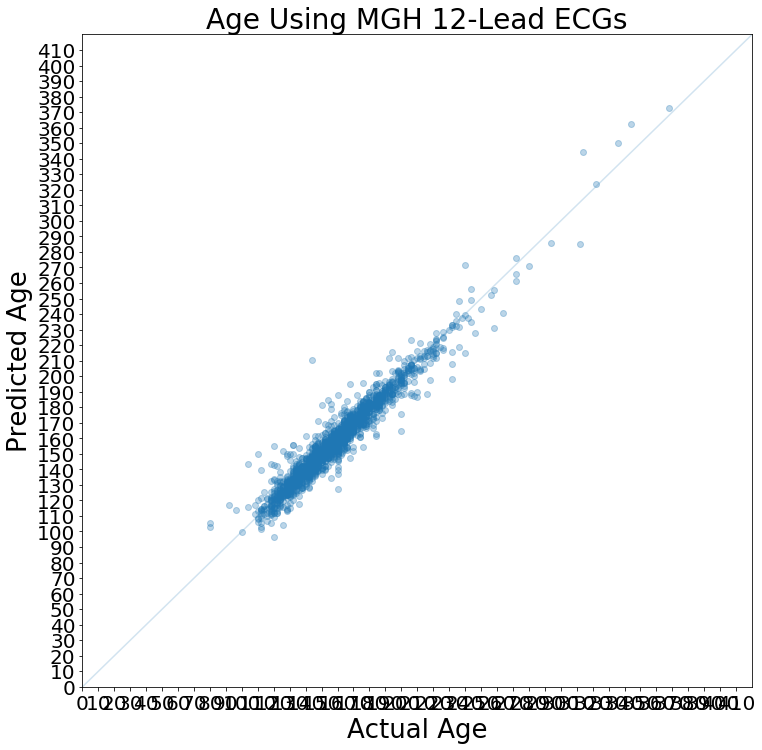

In [197]:
#****to check graphs***
#y_val_list_scaled = np.multiply((y_val_list[i]), 4)

#PR single-lead- 'trained_corrected_60k_pr_1_fold_1_round2.h5'
#PR 12-lead 'trained_corrected_60k_pr_12lead_1_fold_1.h5'
#age single lead- 'trained_corrected_60k_age_1_fold_0_round2.h5'
#age 12-lead- 'trained_corrected_60k_age_12lead_1_fold_0_round2.h5'
#agesexmatched age singel lead- ''trained_agesexmatched_60k_age_1_fold_0_round2.h5'


i=0
X_train_list_scaled = np.divide(X_train_list[i], 4000)
X_val_list_scaled = np.divide(X_val_list[i], 4000)

y_train_list_scaled = y_train_list[i]      #for PR
y_val_list_scaled = y_val_list[i]

#y_train_list_scaled = np.multiply((y_train_list[i]), 4)   #for age
#y_val_list_scaled = np.multiply((y_val_list[i]), 4)

model = load_model('trained_corrected_60k_pr_12lead_1_fold_1.h5') #, custom_objects={'AdamW':adamw})
#model = load_model('trained_pr_first_1000_58_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})

preds_val = model.predict(X_val_list_scaled, verbose=1, batch_size=256)
preds_val = preds_val.reshape(preds_val.shape[0])

#for age
#y_val_list_scaled = np.divide((y_val_list_scaled), 4)
#preds_val = np.divide((preds_val), 4)

spearman = stats.spearmanr(preds_val, y_val_list_scaled)
pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(12,12)) 
plt.scatter(y_val_list_scaled, preds_val, alpha=0.3)
    
ax.set_title('Age Using MGH 12-Lead ECGs', fontsize=28)

ax.set(xlim = [0, 420], ylim = [0, 420])
plt.xticks(range(0, 420, 10), fontsize=20)
plt.yticks(range(0, 420, 10), fontsize=20)
plt.xlabel('Actual Age', fontsize=26)
plt.ylabel('Predicted Age', fontsize=26)

ax.plot([0, 420], [0,420], alpha=0.2)
plt.show()



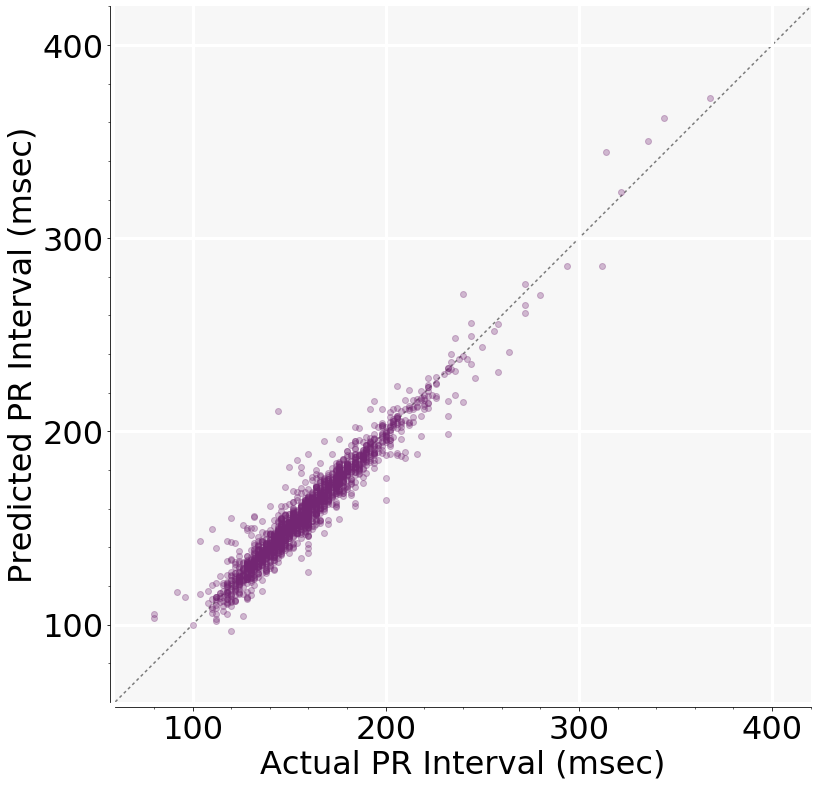

In [198]:
#for pr

#for PR, range 60-420
#for age, range 15-105
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(y_val_list_scaled, preds_val, color='#732673', alpha = 0.3)
lims = [60, 420]
    #np.min([60, 60]),  # min of both axes
    #np.max([420, 420]),  # max of both axes

ax.plot(lims, lims, alpha=0.75, zorder=0, color='#505050', linestyle='--', dashes = [2,2])
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.set_xlim([-0.02, 1.0])
#ax.set_ylim([-0.02, 1.05])
#ax.set_title('PR Interval Using AMC Single-Lead ECGs', fontsize=34)
ax.set_xlabel('Actual PR Interval (msec)')
ax.set_ylabel('Predicted PR Interval (msec)')
ax.set_facecolor('#f7f7f7')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
#ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
#ax.legend(loc='best', frameon=False)
plt.yticks(np.arange(100, 405, 100))
plt.minorticks_on()
plt.tight_layout()
plt.rcParams.update({'font.size': 32})
plt.show()
#outfile = "test.png"
#fig.savefig(outfile)
#plt.close(fig)

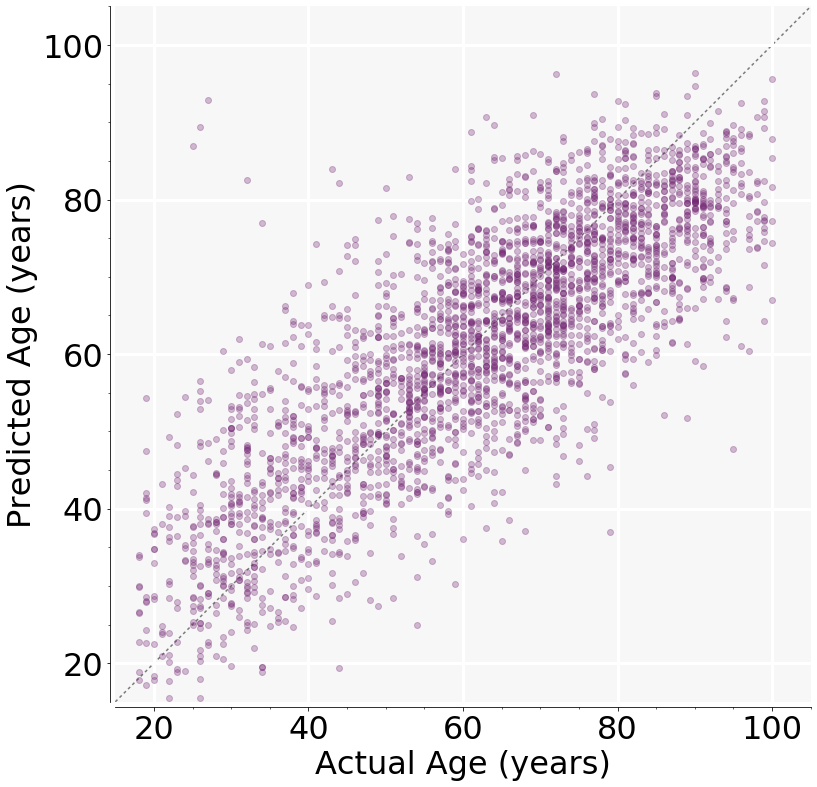

In [157]:
#for age

#for PR, range 60-420
#for age, range 15-105
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(y_val_list_scaled, preds_val, color='#732673', alpha = 0.3)
lims = [15, 105]
    #np.min([60, 60]),  # min of both axes
    #np.max([420, 420]),  # max of both axes

ax.plot(lims, lims, alpha=0.75, zorder=0, color='#505050', linestyle='--', dashes = [2,2])
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.set_xlim([-0.02, 1.0])
#ax.set_ylim([-0.02, 1.05])
#ax.set_title('PR Interval Using AMC Single-Lead ECGs', fontsize=34)
ax.set_xlabel('Actual Age (years)')
ax.set_ylabel('Predicted Age (years)')
ax.set_facecolor('#f7f7f7')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
#ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
#ax.legend(loc='best', frameon=False)
plt.yticks(np.arange(20, 110, 20))
plt.minorticks_on()
plt.tight_layout()
plt.rcParams.update({'font.size': 32})
plt.show()
#outfile = "test.png"
#fig.savefig(outfile)
#plt.close(fig)

In [17]:
grey97='#f7f7f7'
steelblue='#4682b4'
darkorange3="#cd6600"
grey30='#4d4d4d'
grey50='#7f7f7f'

title='PR Interval Using MGH Single-Lead ECGs'
xmax = 410
ymax = 410
xlabel = 'Observed'
alpha = 0.1


plot=(ggplot() \
    +aes(x=y_val_list_scaled,y=preds_val) \
    +geom_point(alpha=alpha) \
    +theme(axis_title_x=element_text(size=22),axis_title_y=element_text(size=22),axis_text_x=element_text(size=22,angle=0,hjust=0.5),axis_text_y=element_text(size=22)) \ 
    +theme(panel_background=element_rect(fill=grey97)) \
    +geom_abline(intercept=0,slope=1,color=grey50) \
    +labs(title=title) \
    +theme(plot_title=element_text(size=26,hjust=0.5)) \
    +ylim(0,ymax)+xlim(0,xmax) \
      #+xlab(xlabel)+ylab('Deviation') \
    +geom_text(label='some_label',x=18,y=3,size=12) \
    ) \

plot.save('tempplot.pdf', height=8, width=8, dpi=120) 

NameError: name 'y_val_list_scaled' is not defined

In [ ]:
def scatPlot(data,title,xmax,ymax,xlabel='Observed',pred_key='Predicted',obs_key='Observed',alpha=0.1):
    linModel=LinearRegression()
    linModel.fit(np.array(data[pred_key]).reshape(-1,1),np.array(data[obs_key]).reshape(-1,1))
    print('intercept:',linModel.intercept_,'slope:',linModel.coef_)
    rho=spearmanr(list(data[pred_key]),list(data[obs_key]))[0]
    print(rho)
    label='$\\rho$='+str(round(rho,2))
    plot=(ggplot(data)
     +aes(x=pred_key,y=obs_key)
     +geom_point(alpha=alpha)
     +theme(axis_title_x='Actual PR'(size=22),axis_title_y='Predicted PR'(size=22),axis_text_x='Actualx'(size=22,angle=0,hjust=0.5),axis_text_y='Actualy'(size=22))
     +theme(panel_background=element_rect(fill=grey97))
     +geom_abline(intercept=0,slope=1,color=grey50)
     +labs(title=title)
     +theme(plot_title=element_text(size=26,hjust=0.5))
     +ylim(0,ymax)+xlim(0,xmax)
     #+xlab(xlabel)+ylab('Deviation')
     +geom_text(label=label,x=18,y=3,size=12)
    )
    
    return plot

In [ ]:
plotsp.save(SCATPLOT_FILE_TRUNC+'_video.pdf',height=8,width=8,dpi=120)

In [ ]:
TARGET="BWHTest"
LABEL='E'
RANGE=300
SRC_FILE ='results'+TARGET+'_withBL.txt'
BAPLOT_FILE_TRUNC='BA_PLOT_'+TARGET
SCATPLOT_FILE_TRUNC='SCAT_PLOT_'+TARGET
grey97='#f7f7f7'
steelblue='#4682b4'
darkorange3="#cd6600"
grey30='#4d4d4d'
grey50='#7f7f7f'


def BAPlot(data,title,xmin,xmax,xlabel='Observed',pred_key='Predicted',obs_key='Observed',alpha=0.1,yscale=10):
    ytxt=0.9*yscale
    deviation=np.array(list(data[pred_key]))-np.array(list(data[obs_key]))
    y025=np.percentile(deviation,2.5)
    y125=np.percentile(deviation,12.5)
    y250=np.percentile(deviation,25)
    y500=np.percentile(deviation,50)
    y750=np.percentile(deviation,75)
    y875=np.percentile(deviation,87.5)
    y975=np.percentile(deviation,97.5)
    data['BADeviation']=deviation
    
    medErr=np.median(np.abs(np.array(list(data[pred_key]))-np.array(list(data[obs_key]))))
    label='median error='+str(round(medErr,2))
    plot=(ggplot(data)
     +aes(x=obs_key,y='BADeviation')
     +geom_point(alpha=alpha)
     +theme(axis_title_x=element_text(size=22),axis_title_y=element_text(size=22),axis_text_x=element_text(size=22,angle=0,hjust=0.5),axis_text_y=element_text(size=22))
     +theme(panel_background=element_rect(fill=grey97))
     +geom_hline(yintercept=y025,color=steelblue,linetype='dashed',size=1)
     +geom_hline(yintercept=y250,color=darkorange3,linetype='dashed',size=1.5)
     +geom_hline(yintercept=y750,color=darkorange3,linetype='dashed',size=1.5)
     +geom_hline(yintercept=y975,color=steelblue,linetype='dashed',size=1)
     +geom_hline(yintercept=y500,color=grey30,size=1)
     +labs(title=title)
     +theme(plot_title=element_text(size=26,hjust=0.5))
     +ylim(-yscale,yscale)+xlim(xmin,xmax)
     +xlab(xlabel)+ylab('Deviation')
     +geom_text(label=label,x=18,y=3,size=12)
    )
    
    return plot

def scatPlot(data,title,xmax,ymax,xlabel='Observed',pred_key='Predicted',obs_key='Observed',alpha=0.1):
    linModel=LinearRegression()
    linModel.fit(np.array(data[pred_key]).reshape(-1,1),np.array(data[obs_key]).reshape(-1,1))
    print('intercept:',linModel.intercept_,'slope:',linModel.coef_)
    rho=spearmanr(list(data[pred_key]),list(data[obs_key]))[0]
    print(rho)
    label='$\\rho$='+str(round(rho,2))
    plot=(ggplot(data)
     +aes(x=pred_key,y=obs_key)
     +geom_point(alpha=alpha)
     +theme(axis_title_x=element_text(size=22),axis_title_y=element_text(size=22),axis_text_x=element_text(size=22,angle=0,hjust=0.5),axis_text_y=element_text(size=22))
     +theme(panel_background=element_rect(fill=grey97))
     +geom_abline(intercept=0,slope=1,color=grey50)
     +labs(title=title)
     +theme(plot_title=element_text(size=26,hjust=0.5))
     +ylim(0,ymax)+xlim(0,xmax)
     #+xlab(xlabel)+ylab('Deviation')
     +geom_text(label=label,x=18,y=3,size=12)
    )
    
    return plot
    
srcDF=pd.read_csv(SRC_FILE,sep='\t')

baplot=BAPlot(srcDF,LABEL,0,RANGE,yscale=RANGE/2)#,pred_key='study_median')
baplot.save(BAPLOT_FILE_TRUNC+'_video.pdf',height=6,width=12,dpi=120)

sp=scatPlot(srcDF,LABEL,RANGE,RANGE)
sp.save(SCATPLOT_FILE_TRUNC+'_video.pdf',height=8,width=8,dpi=120)


In [ ]:
#to continue training
y_val_list_scaled = np.multiply((y_val_list_scaled), 4)

model = load_model(filename_base + '_fold_' + str(i) + '.h5')
                   
history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
best_epoch = len(history.history['val_mean_squared_error']) - num_patience
mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
mse_hist = history.history['mean_squared_error']
val_mse_hist = history.history['val_mean_squared_error']

model = load_model(filename_base + '_fold_' + str(i) + '.h5')  #, custom_objects={'AdamW':adamw})
preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=256)
preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
    #y_val_list_scaled = np.divide((y_val_list_scaled), 4)
    #preds_val = np.divide((preds_val_initial), 4)
    
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

spearman = stats.spearmanr(preds_val, y_val_list_scaled)
pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
    
best_epochs.append(best_epoch)
mses.append(mse_model)
val_mses.append(val_mse_model)
mse_hists.append(mse_hist)
val_mse_hists.append(val_mse_hist)
spearmans.append(spearman)
pearsons.append(pearson)
mean_aes.append(mean_ae)
median_aes.append(median_ae)

In [ ]:
#Binary classification

In [ ]:
suffix = 'sex_60k'
#suffix = 'pr_as_binary'
#suffix = 'sex_8k'
#suffix = 'pr_12lead_2d'

In [ ]:
suffix = '100k_diabetes'

In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_2'
print(filename_base)

in_neurons=5000

In [ ]:
#single-lead model

inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

c1 = Conv1D(32,8, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
#c2 = MaxPooling1D(pool_size=1, strides=4) (c2)

c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=8, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=16, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1, activation='sigmoid') (final)

In [ ]:
#changed to Adam, changed batch size

set_loss = 'binary_crossentropy'    #'mean_squared_error'
set_metrics = ['accuracy']                      #['mean_squared_error']

num_batch_size=64   #180
num_epochs=500
num_patience=100
stopping_min_epochs=100
weight_d = 0 #0.000001  

#adamw = AdamW(weight_decay=weight_d)
adam = optimizers.Adam()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adam, loss = set_loss, metrics= set_metrics)
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
y_train_list_scaled = y_train_list[0]
y_val_list_scaled = y_val_list[0]

In [ ]:
#removed age scaling

#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))
X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)

#y_train_list_scaled = np.multiply((y_train_list[0]), 4)
#y_val_list_scaled = np.multiply((y_val_list[0]), 4)

#padding to replicate Mayo Clinic paper
#X_train_list_scaled = np.pad(X_train_list_scaled, pad_width=((0,0),(0,0),(60,60),(0,0)))
#X_val_list_scaled = np.pad(X_val_list_scaled, pad_width=((0,0),(0,0),(60,60),(0,0)))


#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
#lr_finder = LRFinder(min_lr=1e-4, max_lr=1e-1, steps_per_epoch=np.ceil(X_train_list_scaled.shape[0]/num_batch_size), epochs=1)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
#dm

In [ ]:
#changed to Adam
#took out one cycle


#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    #adamw = AdamW(weight_decay=weight_d)
    adam = optimizers.Adam()  #, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.compile(optimizer= adam, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    #model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    
    
    #corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    #early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    earlystopper = EarlyStopping(monitor = 'val_accuracy', mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
    checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_accuracy', mode='max', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    #model = load_model(filename_base + '_fold_' + str(i) + '.h5')

    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    


    

In [ ]:
#i=0
#filename_base = 'trained_' + suffix + '_2'

onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
#earlystopper = EarlyStopping(monitor = 'val_accuracy', mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '_round2.h5', monitor = 'val_accuracy', mode='max', verbose=1, save_best_only = True)



model = load_model(filename_base + '_fold_' + str(i) + '.h5')
                   
history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
#i=0
#filename_base = 'trained_' + suffix + '_2'

onecyc = OneCycle(lr_range=(0.0001, 0.001), momentum_range=(0.95,0.85))
    
#earlystopper = EarlyStopping(monitor = 'val_accuracy', mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '_round3.h5', monitor = 'val_accuracy', mode='max', verbose=1, save_best_only = True)



model = load_model(filename_base + '_fold_' + str(i) + '_round2.h5')
                   
history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
model = load_model(filename_base + '_fold_' + str(i) + '.h5')  #, custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list_scaled, verbose=1, batch_size=256)

In [ ]:
#checking graphs

In [12]:
#for test sets

y_train_list_scaled = ecg_y_k
y_val_list_scaled = ecg_y_k

X_train_list_scaled = np.divide(ecg_X_k,4000)
X_val_list_scaled = np.divide(ecg_X_k, 4000)

In [238]:
y_train_list_scaled = y_train_list[0]
y_val_list_scaled = y_val_list[0]

X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)

In [13]:
#for diabetes- 'trained_100k_diabetes_1_fold_0_round2.h5'
#for sex single lead- trained_corrected_60k_sex_2_fold_0_round3.h5
#for sex 12-lead- 'trained_corrected_60k_sex_1_12lead_fold_0.h5'
#for htn- 'trained_100k_htn_2_fold_0_round2.h5'
#for benzo- 'trained_100k_benzo_1_fold_0_round2.h5'
#for ssri- 'trained_100k_ssri_1_fold_0_round3.h5'

model = load_model('trained_corrected_60k_sex_1_12lead_fold_0.h5')  #, custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list_scaled, verbose=1, batch_size=256)

2908/2908 [==============================] - 6s 2ms/sample


In [14]:
fpr, tpr, _ = roc_curve(y_val_list_scaled, preds_val)
roc_auc = auc(fpr, tpr)

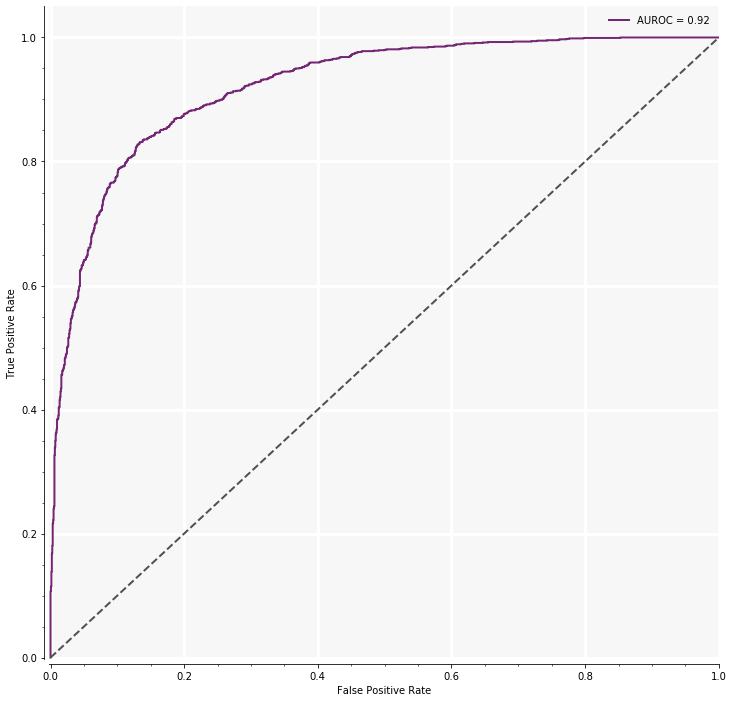

In [15]:

lw = 2
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fpr, tpr, color='#732673',
         lw=lw, label='AUROC = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], color='#505050', lw=lw, linestyle='--')
ax.set_xlim([-0.002, 1.0])
ax.set_ylim([-0.002, 1.05])
#ax.set_title('Diabetes Using AMC Single-Lead ECGs', fontsize=36)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_facecolor('#f7f7f7')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
#ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(loc='best', frameon=False)
plt.minorticks_on()
plt.rcParams.update({'font.size': 34})
plt.show()
outfile = "test.png"
fig.savefig(outfile)
plt.close(fig)

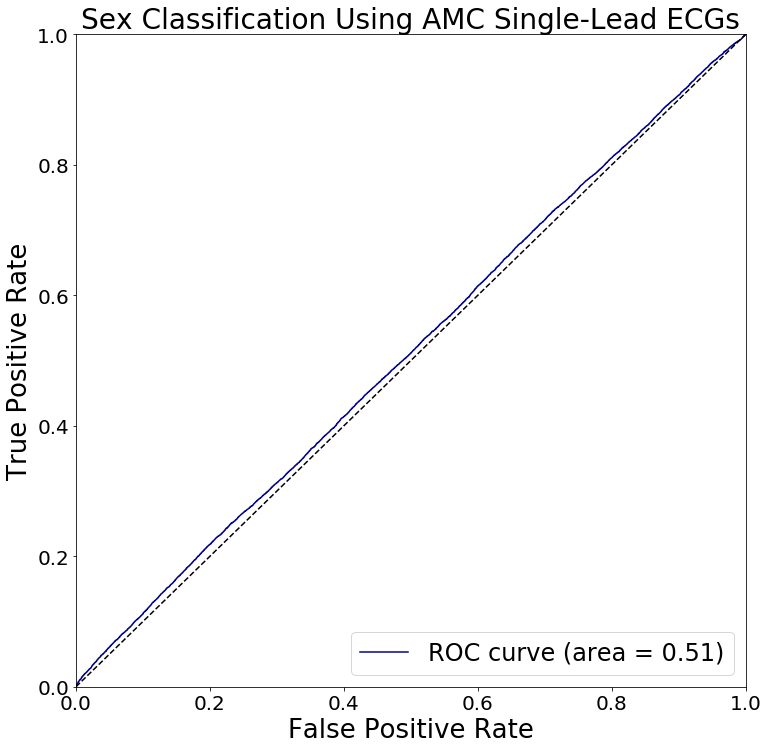

In [231]:
plt.figure(figsize=(12,12))
lw = 1.5
plt.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate', fontsize=26)
plt.ylabel('True Positive Rate', fontsize=26)
plt.title('Sex Classification Using AMC Single-Lead ECGs', fontsize=28)
plt.legend(loc="lower right", fontsize=24)
plt.show()

In [ ]:
#i=0
#filename_base = 'trained_' + suffix + '_2'

onecyc = OneCycle(lr_range=(0.00005, 0.0005), momentum_range=(0.95,0.85))
    
#earlystopper = EarlyStopping(monitor = 'val_accuracy', mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
#checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_accuracy', mode='max', verbose=1, save_best_only = True)



model = load_model(filename_base + '_fold_' + str(i) + '.h5')
                   
history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[checkpointer, onecyc, earlystopper])   #[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
model = load_model(filename_base + '_fold_' + str(i) + '.h5')  #, custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list_scaled, verbose=1, batch_size=256)

In [ ]:
fpr, tpr, _ = roc_curve(y_val_list_scaled, preds_val)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#decreasing kernel at end; adding weight norm to last dilation block

In [ ]:
#also good (3)
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)
#c1 = SpatialDropout1D(0.2) (c1)

c1 = Conv1D(32,8, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = SpatialDropout1D(0.1) (c1)

s1 = Conv1D(16, 1, padding='same') (c1)
s1 = BatchNormalization() (s1)

#c2 = Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c1)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.3) (c2)
#c2 = Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.3) (c2)

#s2 = Conv1D(16, 1, padding='same', use_bias=False) (c2)
#s2 = BatchNormalization() (s2)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c2)
c3 = WeightNormalization(Conv1D(16,6, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,6, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,4, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,4, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

c7 = Conv1D(1, 3, use_bias=False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)

#c7 = Conv1D(64, 3, use_bias = False) (c7)
#c7 = BatchNormalization() (c7)
#c7 = Activation('relu') (c7)

#final = GlobalAvgPool1D() (c4)

#c6 = Dropout(0.1) (c6)
#final = Dense(1, activation='relu') (c7)
final = Flatten() (c7)
#final = Dropout(0.05) (final)
#final = Dense(10, activation='relu') (final)
#final = Dropout(0.2) (final)
outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']

num_batch_size=1024
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0 #0.000001  

adamw = AdamW(weight_decay=weight_d)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))
X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)
y_train_list_scaled = np.multiply((y_train_list[0]), 4)
y_val_list_scaled = np.multiply((y_val_list[0]), 4)
#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
#lr_finder = LRFinder(min_lr=1e-3, max_lr=0.1, steps_per_epoch=np.ceil(3277/num_batch_size), epochs=3)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    #earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=1024)
    preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
    y_val_list_scaled = np.divide((y_val_list_scaled), 4)
    preds_val = np.divide((preds_val_initial), 4)
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

    spearman = stats.spearmanr(preds_val, y_val_list_scaled)
    pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
    median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)




    

In [ ]:
print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[200:1000])
plt.plot(mean_val_mse[200:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list_scaled, scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH Single-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list_scaled, preds_val, s=10)

ax.set(xlim = [0, 110], xticks = np.arange(0, 110, 10),
       ylim = [0, 110], yticks = np.arange(0, 110, 10),
       xlabel = 'Actual Age',
       ylabel = 'Predicted Age')
ax.plot([0, 110], [0,110], alpha=0.2)
plt.show()

In [ ]:
#keepign weight norm of last diilation block increasing kernel again to 8; increasing filters with a max pool near end

In [ ]:
#also good (3)
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)
#c1 = SpatialDropout1D(0.2) (c1)

c1 = Conv1D(32,8, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = SpatialDropout1D(0.1) (c1)

s1 = Conv1D(32, 1, padding='same') (c1)
s1 = BatchNormalization() (s1)

#c2 = Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c1)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.3) (c2)
#c2 = Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.3) (c2)

#s2 = Conv1D(16, 1, padding='same', use_bias=False) (c2)
#s2 = BatchNormalization() (s2)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c2)
c3 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

c7 = Conv1D(16, 3, use_bias=False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)
c7 = MaxPooling1D(1, strides=2) (c7)

#c7 = Conv1D(64, 3, use_bias = False) (c7)
#c7 = BatchNormalization() (c7)
#c7 = Activation('relu') (c7)

#final = GlobalAvgPool1D() (c4)

#c6 = Dropout(0.1) (c6)
#final = Dense(1, activation='relu') (c7)
final = Flatten() (c7)
#final = Dropout(0.05) (final)
#final = Dense(10, activation='relu') (final)
#final = Dropout(0.2) (final)
outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']

num_batch_size=1024
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0 #0.000001  

adamw = AdamW(weight_decay=weight_d)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))
X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)
y_train_list_scaled = np.multiply((y_train_list[0]), 4)
y_val_list_scaled = np.multiply((y_val_list[0]), 4)
#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
#lr_finder = LRFinder(min_lr=1e-3, max_lr=0.1, steps_per_epoch=np.ceil(3277/num_batch_size), epochs=3)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    #earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=1024)
    preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
    y_val_list_scaled = np.divide((y_val_list_scaled), 4)
    preds_val = np.divide((preds_val_initial), 4)
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

    spearman = stats.spearmanr(preds_val, y_val_list_scaled)
    pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
    median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)




    

In [ ]:
print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[200:1000])
plt.plot(mean_val_mse[200:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list_scaled, scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH Single-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list_scaled, preds_val, s=10)

ax.set(xlim = [0, 110], xticks = np.arange(0, 110, 10),
       ylim = [0, 110], yticks = np.arange(0, 110, 10),
       xlabel = 'Actual Age',
       ylabel = 'Predicted Age')
ax.plot([0, 110], [0,110], alpha=0.2)
plt.show()

In [ ]:
#again weight norm at end, but also avg pool before last layer

In [ ]:
#also good (3)
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)
#c1 = SpatialDropout1D(0.2) (c1)

c1 = Conv1D(32,8, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = SpatialDropout1D(0.1) (c1)

s1 = Conv1D(16, 1, padding='same') (c1)
s1 = BatchNormalization() (s1)

#c2 = Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c1)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.3) (c2)
#c2 = Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.3) (c2)

#s2 = Conv1D(16, 1, padding='same', use_bias=False) (c2)
#s2 = BatchNormalization() (s2)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c2)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

c7 = Conv1D(16, 3, use_bias=False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)

#c7 = Conv1D(64, 3, use_bias = False) (c7)
#c7 = BatchNormalization() (c7)
#c7 = Activation('relu') (c7)

c7 = GlobalAvgPool1D() (c7)

#c6 = Dropout(0.1) (c6)
#final = Dense(1, activation='relu') (c7)
final = Flatten() (c7)
#final = Dropout(0.05) (final)
#final = Dense(10, activation='relu') (final)
#final = Dropout(0.2) (final)
outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']

num_batch_size=1024
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0 #0.000001  

adamw = AdamW(weight_decay=weight_d)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))
X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)
y_train_list_scaled = np.multiply((y_train_list[0]), 4)
y_val_list_scaled = np.multiply((y_val_list[0]), 4)
#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
#lr_finder = LRFinder(min_lr=1e-3, max_lr=0.1, steps_per_epoch=np.ceil(3277/num_batch_size), epochs=3)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    #earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=1024)
    preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
    y_val_list_scaled = np.divide((y_val_list_scaled), 4)
    preds_val = np.divide((preds_val_initial), 4)
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

    spearman = stats.spearmanr(preds_val, y_val_list_scaled)
    pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
    median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)




    

In [ ]:
print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[200:1000])
plt.plot(mean_val_mse[200:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list_scaled, scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH Single-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list_scaled, preds_val, s=10)

ax.set(xlim = [0, 110], xticks = np.arange(0, 110, 10),
       ylim = [0, 110], yticks = np.arange(0, 110, 10),
       xlabel = 'Actual Age',
       ylabel = 'Predicted Age')
ax.plot([0, 110], [0,110], alpha=0.2)
plt.show()

In [ ]:
#also good (3)
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)
#c1 = SpatialDropout1D(0.2) (c1)

c1 = Conv1D(32,8, padding='same', use_bias=False, strides=2, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = SpatialDropout1D(0.1) (c1)

s1 = Conv1D(16, 1, padding='same') (c1)
s1 = BatchNormalization() (s1)

#c2 = Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c1)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.3) (c2)
#c2 = Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c2)
c2 = WeightNormalization(Conv1D(32,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.3) (c2)

#s2 = Conv1D(16, 1, padding='same', use_bias=False) (c2)
#s2 = BatchNormalization() (s2)

#c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c2)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
#c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

c3 = Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal') (c3)
#c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=8, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.3) (c3)
c3 = Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal') (c3)
#c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=16, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.3) (c3)

c7 = Conv1D(1, 3, use_bias=False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)

#c7 = Conv1D(64, 3, use_bias = False) (c7)
#c7 = BatchNormalization() (c7)
#c7 = Activation('relu') (c7)

#final = GlobalAvgPool1D() (c4)

#c6 = Dropout(0.1) (c6)
#final = Dense(1, activation='relu') (c7)
final = Flatten() (c7)
#final = Dropout(0.05) (final)
#final = Dense(10, activation='relu') (final)
#final = Dropout(0.2) (final)
outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']

num_batch_size=1024
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0 #0.000001  

adamw = AdamW(weight_decay=weight_d)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#X_train_list_scaled = np.multiply(np.sign(X_train_list[0]), np.log(np.abs(X_train_list[0])+1)) #log-modulus transform- https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
#X_val_list_scaled = np.multiply(np.sign(X_val_list[0]), np.log(np.abs(X_val_list[0])+1))
X_train_list_scaled = np.divide(X_train_list[0],4000)
X_val_list_scaled = np.divide(X_val_list[0], 4000)
y_train_list_scaled = np.multiply((y_train_list[0]), 4)
y_val_list_scaled = np.multiply((y_val_list[0]), 4)
#sns.distplot(X_train_list_scaled)

#Normalization
#X_train_list_scaled = np.log(X_train_list[0])
#print(np.mean(X_train_list_scaled))
#print(np.std(X_train_list_scaled))

#X_val_list_scaled = (X_val_list[0]-np.mean(X_val_list[0]))/370
#print(np.mean(X_val_list_scaled))
#print(np.std(X_val_list_scaled))

In [ ]:
#lr_finder = LRFinder(min_lr=1e-3, max_lr=0.1, steps_per_epoch=np.ceil(3277/num_batch_size), epochs=3)

#model.fit(X_train_list_scaled, y_train_list_scaled, callbacks=[lr_finder])
#lr_finder.plot_loss()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list_scaled, y_val_list_scaled, filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
    
    #earlystopper = EarlyStopping(monitor = 'val_mean_squared_error', mode='min', patience=num_patience, verbose=1)  #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename_base + '_fold_' + str(i) + '.h5', monitor = 'val_mean_squared_error', mode='min', verbose=1, save_best_only = True)


    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val_initial = model.predict(X_val_list_scaled, verbose=1, batch_size=1024)
    preds_val_initial = preds_val_initial.reshape(preds_val_initial.shape[0])
    
    #****
    y_val_list_scaled = np.divide((y_val_list_scaled), 4)
    preds_val = np.divide((preds_val_initial), 4)
    #y_train_list_scaled = np.divide((y_train_list[0]-18),41) - 1
    
    #preds_val = np.multipy((preds_val_initial), 82) + 18
    #y_train_list_scaled = np.multipiy((y_train_list_scaled), 82) +18

    spearman = stats.spearmanr(preds_val, y_val_list_scaled)
    pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
    mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
    median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)




    

In [ ]:
print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[200:1000])
plt.plot(mean_val_mse[200:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list_scaled, scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH Single-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list_scaled, preds_val, s=10)

ax.set(xlim = [0, 110], xticks = np.arange(0, 110, 10),
       ylim = [0, 110], yticks = np.arange(0, 110, 10),
       xlabel = 'Actual Age',
       ylabel = 'Predicted Age')
ax.plot([0, 110], [0,110], alpha=0.2)
plt.show()

In [ ]:
y_train_list_scaled = np.multiply((y_train_list[0]), 4)
y_val_list_scaled = np.multiply((y_val_list[0]), 4)

In [ ]:
onecyc2 = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list_scaled, y_train_list_scaled, validation_data = (X_val_list_scaled, y_val_list_scaled), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
#model = load_model('trained_pr_first_1000_58_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})

preds_val = model.predict(X_val_list_scaled, verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

y_val_list_scaled = np.divide((y_val_list_scaled), 4)
preds_val = np.divide((preds_val), 1)

spearman = stats.spearmanr(preds_val, y_val_list_scaled)
pearson = stats.pearsonr(preds_val, y_val_list_scaled)
    
mean_ae = np.mean(abs(preds_val - y_val_list_scaled))
median_ae = np.median(abs(preds_val - y_val_list_scaled))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH Single-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list_scaled, preds_val, s=10)

ax.set(xlim = [0, 110], xticks = np.arange(0, 110, 10),
       ylim = [0, 110], yticks = np.arange(0, 110, 10),
       xlabel = 'Actual Age',
       ylabel = 'Predicted Age')
ax.plot([0, 110], [0,110], alpha=0.2)
plt.show()


In [ ]:
y_val_list_scaled

In [ ]:
np.std(y_val_list[i])

In [ ]:
y_train_list[i].shape

In [ ]:
far_preds = np.where(abs(preds_val - y_val_list[i])>25)

In [ ]:
far_preds[0]

In [ ]:
for far_pred in far_preds[0]:
    print('Index: ', far_pred, ', Actual: ', y_val_list[i][far_pred], ', Predicted: ', preds_val[far_pred].round(1), \
          ', Difference: ', (preds_val[far_pred] - y_val_list[i][far_pred]).round(1))

In [ ]:
from matplotlib.widgets import Cursor
from matplotlib.widgets import RectangleSelector

In [ ]:
%matplotlib notebook

In [ ]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)
    
    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.random.rand(10))

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
import matplotlib.pyplot as plt
class LineDrawer(object):
    lines = []
    def draw_line(self):
        ax = plt.gca()
        xy = plt.ginput(2)

        x = [p[0] for p in xy]
        y = [p[1] for p in xy]
        line = plt.plot(x,y)
        ax.figure.canvas.draw()

        self.lines.append(line)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.random.rand(10))

def onclick(event):
    a='xdata=%f, ydata=%f' % (event.xdata, event.ydata)
    x = event.xdata
    temp.append(x)
    L =  ax.axvline(x=x)
    ax.set_title(a)
    ax.fig.canvas.draw()

def onrelease(event):
    x2= event.xdata
    b = 'Start: %.1f, End: %.1f, PR interval: %.1f' % (temp[0], x2, (x2 - temp[0]))
    L =  ax.axvline(x=x2)
    ax.set_title(b)
    ax.fig.canvas.draw()
    
temp = []
cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('button_release_event', onrelease)


In [ ]:
temp

In [ ]:
indx = 9
j= 20    #starting point within first 5000 points
length= 1000

for k in range(1):
    #plt.figure(figsize=(20,5))
    fig, ax = plt.subplots(figsize=(10,5))
    #figure(figsize=(20,5))
    plt.plot(X_val_list[i][indx][(5000*k)+j:(5000*k)+j+length])
    #line, = ax.plot([0], [0])
    #linebuilder = LineBuilder(line)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    #cursor = Cursor(ax, horizOn=True, vertOn = True, color = 'green', linewidth=2.0)
    plt.show()

In [ ]:
i

In [ ]:
X_val_list[0][0][0:100]

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(X_val_list[0][20][0:500])

In [ ]:
#2d array
inputs = Input((12, in_neurons, 1))

c1 = Conv2D(16,(1,4), padding='valid', use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = MaxPooling2D((1, 2)) (c1)
c1 = Dropout(0.1) (c1)

c1 = Conv2D(16,(1,8), padding='valid', use_bias = False, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = MaxPooling2D((1, 4)) (c1)
c1 = Dropout(0.2) (c1)


#s1 = Conv2D(16, (12,4), padding='valid', use_bias=False, kernel_initializer= 'he_normal') (c1)
#s1 = BatchNormalization() (s1)
#s1 = MaxPooling2D((1, 4)) (c1)

c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout2D(0.3) (c2)
c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout2D(0.3) (c2)
#c2 = MaxPooling2D((1, 4)) (c2)


c2 = Conv2D(16,(12,8), padding='same', use_bias = False, kernel_initializer= 'he_normal') (c2)
c2 = BatchNormalization() (c2)
c2 = Activation('relu') (c2)
c2 = Dropout(0.4) (c2)
c2 = MaxPooling2D((12, 1)) (c2)

#c2 = Conv2D(16, (4, 1), use_bias = False, kernel_initializer= 'he_normal') (c2)
#c2 = BatchNormalization() (c2)
#c2 = Activation('relu') (c2)
#c2 = Dropout(0.2) (c2)

c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout2D(0.4) (c3)
c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (c1+c3)
c3 = SpatialDropout2D(0.4) (c3)
c3 = MaxPooling2D((1, 2)) (c3)


#c3 = Conv2D(16,(12,1), padding='valid', use_bias = False, kernel_initializer= 'he_normal') (c3)
#c3 = BatchNormalization() (c3)
#c3 = Activation('relu') (c3)
##c2 = MaxPooling2D((1, 2)) (c3)
#c3 = Dropout(0.3) (c3)
#c3 = MaxPooling2D((1, 8)) (c3)


c7 = Conv2D(16, (1,8), use_bias = False, kernel_initializer= 'he_normal') (c2)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)
c7 = MaxPooling2D((1, 4)) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
#not going below ~400
inputs = Input((12, in_neurons, 1))

c1 = Conv2D(16,(1,4), padding='same', use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = MaxPooling2D((1, 2)) (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv2D(16, (4,1), padding='valid', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)
s1 = MaxPooling2D((1, 4)) (s1)

c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout2D(0.2) (c2)
c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout2D(0.2) (c2)
c2 = MaxPooling2D((1, 4)) (c2)

c2 = Conv2D(16, (4, 1), use_bias = False, kernel_initializer= 'he_normal') (c2)
c2 = BatchNormalization() (c2)
c2 = Activation('relu') (c2)
c2 = Dropout(0.2) (c2)

c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout2D(0.3) (c3)
c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout2D(0.3) (c3)
c3 = MaxPooling2D((1, 8)) (c3)

c7 = Conv2D(16, (9,3), use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_73'
print(filename_base)

in_neurons=5000

In [ ]:
inputs = Input((12, in_neurons, 1))

c1 = Conv2D(16,(1,4), padding='same', use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = MaxPooling2D((1, 2)) (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv2D(16, (4,1), padding='valid', use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)
s1 = MaxPooling2D((1, 4)) (s1)

c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout2D(0.2) (c2)
c2 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout2D(0.2) (c2)
c2 = MaxPooling2D((1, 4)) (c2)

c2 = Conv2D(16, (4, 1), use_bias = False, kernel_initializer= 'he_normal') (c2)
c2 = BatchNormalization() (c2)
c2 = Activation('relu') (c2)
c2 = Dropout(0.2) (c2)

c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout2D(0.3) (c3)
c3 = WeightNormalization(Conv2D(16,(1,8), padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout2D(0.3) (c3)
c3 = MaxPooling2D((1, 8)) (c3)

c7 = Conv2D(16, (9,3), use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=210
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model('trained_' + suffix + '_58' + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_57'
print(filename_base)

in_neurons=60000

In [ ]:
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)


c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)



c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.2) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.2) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.2) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=245
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.0001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_58'
print(filename_base)

in_neurons=60000

In [ ]:
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)


c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)



c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=245
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.0001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_59'
print(filename_base)

in_neurons=60000

In [ ]:
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
#c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)


c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
#c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)



c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
#c3 = SpatialDropout1D(0.2) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=245
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.0001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_60'
print(filename_base)

in_neurons=60000

In [ ]:
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
#c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)


c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
#c2 = SpatialDropout1D(0.2) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
#c2 = SpatialDropout1D(0.2) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)



c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
#c3 = SpatialDropout1D(0.2) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
#c3 = SpatialDropout1D(0.2) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.4) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=245
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.0001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
K.clear_session()
filename_base = 'trained_' + suffix + '_61'
print(filename_base)

in_neurons=60000

In [ ]:
inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
#c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)


c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
#c2 = SpatialDropout1D(0.2) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
#c2 = SpatialDropout1D(0.2) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)



c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
#c3 = SpatialDropout1D(0.2) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
#c3 = SpatialDropout1D(0.2) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.1) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)

In [ ]:
set_loss = 'mean_squared_error'
set_metrics = ['mean_squared_error']
#set_learning_rate = 0.007

num_batch_size=245
num_epochs=500
num_patience=200
stopping_min_epochs=400
weight_d = 0  # 0.0000001

adamw = AdamW(weight_decay=weight_d)
#adam = optimizers.Adam(learning_rate= set_learning_rate)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= adamw, loss = set_loss, metrics= ['mean_squared_error'])
model.save_weights('temp4.h5')

model.summary()

In [ ]:
#ocp = OneCycle(lr_range=(0.0007, 0.007), momentum_range=(0.94,0.85))
#ocp.test_run(128)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
#lr_finder = LRFinder(start_lr= 0.0001, end_lr= 1, max_steps=20)

#model.fit(X_train_list[0], y_train_list[0], callbacks=[lr_finder])
#lr_finder.plot()

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(1):
    
    K.clear_session()

    adamw = AdamW(weight_decay=weight_d)
    #adam = optimizers.Adam(learning_rate= set_learning_rate, clipnorm=1.)
    #rmsprop = optimizers.RMSprop(learning_rate= set_learning_rate, clipnorm=1.)
    #sgdopt = optimizers.SGD(learning_rate= set_learning_rate, clipnorm=1.)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer= adamw, loss = set_loss, metrics= set_metrics)
    model.load_weights('temp4.h5')
    
    
    
    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)
    
    onecyc = OneCycle(lr_range=(0.0005, 0.005), momentum_range=(0.95,0.85))
    
    #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()


    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('Best epoch: ', best_epochs)
print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


#print('Mean MSE: ', np.mean(mses))
#print('Mean val_MSE: ', np.mean(val_mses))
#print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
#print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
#print('Mean of Mean abs error: ', np.mean(mean_aes))
#print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#for j in range(len(mse_hists)):
#    plt.plot(mse_hists[j])
#    plt.plot(val_mse_hists[j])
#    plt.show()


    

In [ ]:
now = datetime.now()

current_time2 = now.strftime("%H:%M:%S")
print("Start time: ", current_time)
print("End time: ", current_time2)

In [ ]:
plt.plot(mean_mse[60:1000])
plt.plot(mean_val_mse[60:1000])

In [ ]:
bland_altman_plot(preds_val, y_val_list[i], scatter_kwds={'s':10}, title='MGH/BWH 12-Lead ECGs (10 secs)')



In [ ]:
fig, ax = plt.subplots(figsize=(7,7)) #(1, 1, figsize=(12, 12))
    
ax.set_title('MGH/BWH 12-Lead ECGs (10 secs)', fontsize=14)
ax.scatter(y_val_list[i], preds_val, s=10)

ax.set(xlim = [0, 420], xticks = np.arange(0, 420, 50),
       ylim = [0, 420], yticks = np.arange(0, 420, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
ax.plot([0, 450], [0,450], alpha=0.2)
plt.show()

In [ ]:
onecyc2 = OneCycle(lr_range=(0.001, 0.01), momentum_range=(0.95,0.85))
history2 = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, onecyc, early_stopper]) #tensorboard_callback])
    

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [ ]:
i=0
model = load_model(filename_base + '_fold_' + str(i) + '.h5', custom_objects={'AdamW':adamw})
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))
    
print('Spearman: ', spearman)
print('Pearson: ', pearson)
print('Mean abs error: ', mean_ae)
print('Median abs error: ', median_ae)


fig, ax = plt.subplots(figsize=(6,6)) #(1, 1, figsize=(12, 12))
    
fig.suptitle('12-Lead ECGs (47)')
ax.scatter(y_val_list[i], preds_val)
ax.set(xlim = [0, 350], xticks = np.arange(0, 350, 50),
       ylim = [0, 350], yticks = np.arange(0, 350, 50),
       xlabel = 'ECG PR Interval',
       ylabel = 'Predicted PR Interval')
plt.show()


In [ ]:
trained_pr_first_1000_40_fold_0.h5 new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
new_model = load_model('trained_pr_first_1000_40_fold_0.h5')

In [ ]:
K.set_value(new_model.optimizer.lr, 0.0001)

In [ ]:
best_epochs = []
mses = []
val_mses = []
mse_hists = []
val_mse_hists = []
spearmans = []
pearsons = []
mean_aes = []
median_aes = []

#for train_index, val_index in group_kfold.split(ecg_X_k, ecg_y_k, ecg_id_k):  #for full 10-fold cross validation

for i in range(0,1):
    

    corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= ('temp_fold_' + str(i) + '.h5'))
    early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
    #checkpointer = ModelCheckpoint(filename, monitor = corr_check, mode='min', verbose=1, save_best_only = True)
    
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    #X_train, X_val = ecg_X_k[train_index], ecg_X_k[val_index]
    #y_train, y_val = ecg_y_k[train_index], ecg_y_k[val_index]
    
    history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, early_stopper]) #tensorboard_callback])
    
    best_epoch = len(history.history['val_mean_squared_error']) - num_patience
    mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
    val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
    mse_hist = history.history['mean_squared_error']
    val_mse_hist = history.history['val_mean_squared_error']

    model = load_model('temp_fold_' + str(i) + '.h5')
    preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
    preds_val = preds_val.reshape(preds_val.shape[0])

    spearman = stats.spearmanr(preds_val, y_val_list[i])
    pearson = stats.pearsonr(preds_val, y_val_list[i])
    
    mean_ae = np.mean(abs(preds_val - y_val_list[i]))
    median_ae = np.median(abs(preds_val - y_val_list[i]))
    
    
    best_epochs.append(best_epoch)
    mses.append(mse_model)
    val_mses.append(val_mse_model)
    mse_hists.append(mse_hist)
    val_mse_hists.append(val_mse_hist)
    spearmans.append(spearman)
    pearsons.append(pearson)
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)

print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)


print('Mean MSE: ', np.mean(mses))
print('Mean val_MSE: ', np.mean(val_mses))
print('Mean Spearman r: ', [np.mean(i) for i in zip(*spearmans)])
print('Mean Pearson r: ', [np.mean(i) for i in zip(*pearsons)])
print('Mean of Mean abs error: ', np.mean(mean_aes))
print('Mean of Median abs error: ', np.mean(median_aes))


mean_mse = [np.mean(i) for i in zip(*mse_hists)]
mean_val_mse = [np.mean(i) for i in zip(*val_mse_hists)]
plt.plot(mean_mse[3:])
plt.plot(mean_val_mse[3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

for j in range(len(mse_hists)):
    plt.plot(mse_hists[j])
    plt.plot(val_mse_hists[j])
    plt.show()

In [ ]:
model = load_model(filename_base + '_fold_' + str(i) + '.h5')

In [ ]:
K.set_value(model.optimizer.lr, 0.0001)

In [ ]:
corr_check = corr_checkpointer(X_val_list[i], y_val_list[i], filepath= (filename_base + '_contfold_' + str(i) + '.h5))
early_stopper = corr_early_stopping(min_epochs=stopping_min_epochs, mode='max', patience=num_patience, verbose=1)  #restore_best_weights not available
  
history = model.fit(X_train_list[i], y_train_list[i], validation_data = (X_val_list[i], y_val_list[i]), batch_size = num_batch_size, epochs=num_epochs, callbacks=[corr_check, early_stopper]) #tensorboard_callback])
    
best_epoch = len(history.history['val_mean_squared_error']) - num_patience
mse_model = history.history['mean_squared_error'][-(num_patience + 1)]
val_mse_model = history.history['val_mean_squared_error'][-(num_patience + 1)]
mse_hist = history.history['mean_squared_error']
val_mse_hist = history.history['val_mean_squared_error']

model = load_model(filename_base + '_contfold_' + str(i) + '.h5')
preds_val = model.predict(X_val_list[i], verbose=1, batch_size=1024)
preds_val = preds_val.reshape(preds_val.shape[0])

spearman = stats.spearmanr(preds_val, y_val_list[i])
pearson = stats.pearsonr(preds_val, y_val_list[i])
    
mean_ae = np.mean(abs(preds_val - y_val_list[i]))
median_ae = np.median(abs(preds_val - y_val_list[i]))

print('MSE: ', mses)
print('Val MSE: ', val_mses)
print('Spearman: ', spearmans)
print('Pearson: ', pearsons)
print('Mean abs error: ', mean_aes)
print('Median abs error: ', median_aes)

In [ ]:
#also good (3)
inputs = Input((in_neurons, 1))

#c1 = BatchNormalization() (inputs)

c1 = Conv1D(16,3, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)
#c1 = SpatialDropout1D(0.2) (c1)


c1 = Conv1D(32,7, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (c1)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = SpatialDropout1D(0.2) (c1)


s1 = Conv1D(64, 1, padding='same', strides=2, use_bias=False) (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv1D(32,7, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.3) (c2)
c2 = WeightNormalization(Conv1D(32,7, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.3) (c2)
c2 = MaxPooling1D(1, strides=2) (c2)

#s2 = Conv1D(16, 1, padding='same', use_bias=False) (c2)
#s2 = BatchNormalization() (s2)

c3 = WeightNormalization(Conv1D(64,7, padding='same', dilation_rate=8, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.4) (c3)
c3 = WeightNormalization(Conv1D(64,7, padding='same', dilation_rate=16, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.4) (c3)
#c3 = MaxPooling1D(1, strides=2) (c3)


c3 = WeightNormalization(Conv1D(64,7, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.4) (c3)
c3 = WeightNormalization(Conv1D(64,7, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.4) (c3)
c3 = MaxPooling1D(1, strides=2) (c3)

#c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
#c3 = SpatialDropout1D(0.3) (c3)
#c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (s1+c3)
#c3 = SpatialDropout1D(0.3) (c3)

c7 = Conv1D(32, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.5) (c7)
c7 = MaxPooling1D(1, strides=2) (c7)

#c7 = Conv1D(64, 3, use_bias = False) (c7)
#c7 = BatchNormalization() (c7)
#c7 = Activation('relu') (c7)

#final = GlobalAvgPool1D() (c4)

#c6 = Dropout(0.1) (c6)
#final = Dense(1, activation='relu') (c7)
final = Flatten() (c7)
#final = Dropout(0.05) (final)
#final = Dense(10, activation='relu') (final)
#final = Dropout(0.2) (final)
outputs = Dense(1) (final)

In [ ]:
'''inputs = Input((in_neurons, 1))

c1 = Conv1D(16,4, padding='same', strides=2, use_bias = False, kernel_initializer= 'he_normal') (inputs)
c1 = BatchNormalization() (c1)
c1 = Activation('relu') (c1)
c1 = Dropout(0.1) (c1)

s1 = Conv1D(16, 8, padding='same', strides=4, use_bias=False, kernel_initializer= 'he_normal') (c1)
s1 = BatchNormalization() (s1)

c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c1)
c2 = Activation('relu') (c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c2)
#c2 = Activation('relu') (c2)
c2 = Activation('relu') (c1+c2)
c2 = SpatialDropout1D(0.1) (c2)
c2 = MaxPooling1D(pool_size=1, strides=4) (c2)

c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=2, kernel_initializer= 'he_normal')) (c2)
c3 = Activation('relu') (c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = WeightNormalization(Conv1D(16,8, padding='same', dilation_rate=4, kernel_initializer= 'he_normal')) (c3)
#c3 = Activation('relu') (c3)
c3 = Activation('relu') (s1+c3)
c3 = SpatialDropout1D(0.1) (c3)
c3 = MaxPooling1D(pool_size=1, strides=8) (c3)

c7 = Conv1D(1, 3, use_bias = False, kernel_initializer= 'he_normal') (c3)
c7 = BatchNormalization() (c7)
c7 = Activation('relu') (c7)
c7 = Dropout(0.3) (c7)

final = Flatten() (c7)

outputs = Dense(1) (final)
'''